Testing a full scoring process on the full set of data, each of the PCA reductions. On each set of data this entails:
- Exact scoring using a range of different neighbors using kNN trained on FULL dataset
  - Can be accomplished in a single run by using kNN to calculate distances to the max neighbor
  - Arbitrarily choosing k=4 to 14
- Average scoring using kNN trained on full dataset
  - Can average output from exact scoring above

- Exact scoring using a range of different neighbors using kNN trained on a sample of the dataset
  - Sample size 10k
  - Averaging exact score over 10 runs
  - Same number of neighbors, k=4 to 14, this is probably probematic since the distances will be inherently larger...
- Average scoring using kNN trained on sample of dataset
  - can average exact scores from above

This will result in 22 scores for every object. 10 based on exact distance to the exact k-th neighbor, 10 based on average exact distance to the k-th nearest sample point, 1 average of exact distances to exact k-th neighbors, and 1 average of average exact distances to k-th nearest sample point.

# Initializing and Importing

In [1]:
# Some standard imports for math and data handling
import sys
import numpy as np
np.set_printoptions(threshold=sys.maxsize)
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import pickle

# Imports for processing specific to this workbook
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from sklearn import preprocessing
from datetime import datetime

# Import the custom code developed for this work
sys.path.append('python')
from clusterOutliers import clusterOutliers as coo
import quarterTools as qt
%matplotlib inline

## Importing Data

In [ ]:
path_to_output = '/home/dgiles/Documents/KeplerLCs/output/'

In [2]:
Q_dict = dict()
for i in range(1,18):
    with open(path_to_output+'Q{}.coo'.format(i),'rb') as file:
        Q_dict['Q{}'.format(i)]=pickle.load(file)

In [9]:
# Checking contents of Q
Q_dict['Q1'].reductions.keys()

dict_keys(['PCA90', 'PCA95', 'PCA99'])

In [1065]:
# A ton of scores are produced for Q1 alone to mess with scoring parameters. 
# These scores are saved in a seperate dataframe. This call loads those scores.
# The call below saves any added scores.
with open('/home/dgiles/Documents/KeplerLCs/output/Q1_extra_scores','rb') as f:
    Q1_scores = pickle.load(f)

In [ ]:
with open('/home/dgiles/Documents/KeplerLCs/output/Q1_extra_scores','wb') as f:
    pickle.dump(Q1_scores,f)

# Scoring

## Distance based

This is essentially the most naive scoring metric given how clusters/outliers are defined. The metric is simply the distance to the k-th neighbor, min-max normalized from 0 to 1.

In [92]:
def dist_scores(data,d2s=None,kmin=4,kmax=14):
    """
    This method scores data based on distance to the k-th neighbor for a range of k's from kmin to kmax
    Args:
        data (Numpy array or Pandas dataframe) - Full set of data, scaled appropriately.
        d2s (Numpy array or Pandas dataframe) - Subset of data to be scored (if None, scores the full dataset)
        kmin (integer) - minimum neighbor to calculate the distance 
        kmax (integer) - maximum neighbor to calculate the distance 
        Note: The original DBSCAN paper suggests choosing k=4 and that k beyond this doesn't provide additional insight.
            Given the increase of d.ata volume I'm not sure this argument holds up, but the heuristic
            continues to enjoy widespread use, we use it as a base.
    Returns:
        scoress (Numpy array) - MinMax scaled scores for data in d2s. 
    """
    if type(d2s)==type(None):
        d2s=data
    nbrs = NearestNeighbors(n_neighbors=kmax+1, algorithm='ball_tree',n_jobs=-1).fit(data)
    distances, indices = nbrs.kneighbors(d2s)
    
    # empty numpy array which will contain scores, one additional column for average score
    scores = np.zeros((kmax-kmin+1,len(distances))) 
    
    # There's probably a better way to do this with numpy arrays, but it's not worth figuring out
    for k in range(kmin,kmax):    
        k_scores = distances[:,k]
        # not using sklearn's preprocessing module bc scaling 1D at a time.
        k_scores = (k_scores-k_scores.min())/(k_scores.max()-k_scores.min()) #min max scaled
        
        scores[k-kmin]=k_scores
    k_av_scores = np.sum(distances[:,4:14],axis=1)
    k_av_scores = (k_av_scores-k_av_scores.min())/(k_av_scores.max()-k_av_scores.min()) #min max scaled
    scores[-1]=k_av_scores
    
    # TODO: readjust scaling so that the extreme outliers don't affect scores of the rest.
    # Potentially scale 90th percentile, define all beyond that as having a score of 1.
    
    return scores

#### Scaling the Q1 data

In [79]:
Q1_data_scaled = qt.data_scaler(Q_dict['Q1'].data)

/home/dgiles/anaconda3/envs/KeplerFull37/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
python/quarterTools.py:90: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  scaled_data = scaler.transform(data)


#### Generating exact scores for k=4 to 14

In [93]:
starttime = datetime.now()
Q1_exact_scores = dist_scores(Q1_data_scaled,kmin=4,kmax=14)
print("Time to calculate scores: {}".format(datetime.now()-starttime))

Time to calculate scores: 0:12:35.767418


#### Putting scores into a dataframe

In [99]:
columns = ['{}'.format(i) for i in range(4,14)]
columns.append('Average')
# First instance of Q1_scores, defines the dataframe. All others will add to this.
Q1_scores = pd.DataFrame(data=Q1_exact_scores.T,columns=columns,index=Q1_data_scaled.index)

The following method calls the previous method, but generates a sample to calculate distances against

In [146]:
def dist_scores_s(data,d2s=None,samp_size=10000,n_iter=10,kmin=4,kmax=14):
    """
    The 's' stands for speed
    Args:
        data (Numpy array or Pandas dataframe) - Full set of data (scaled and culled of irrelevant data)
        d2s (Numpy array or Pandas dataframe) - Subset of data to be scored (optional if interested in a subset)
        k (integer) - Neighbor to which the distance is considered the score
        n_iter (integer) - Number of iterations, 
            ***TODO: if None, will loop until scores converge (not implemented)***
    Returns:
        scores (Numpy array) - MinMax scaled scores for data in d2s. 
        
    Purpose:
        Calculate scores for each point within the dataset in an efficient manner. The score is based on the 
        distance to the k nearest neighbor, but in this implementation a reference sample is generated and
        used to calculate distances instead of the genuine neighbors. This is in order to make this process 
        scalable to larger datasets, calculating the actual k nearest neighbor distance for all points for
        high dimensional data is not particularly efficient.
        Consideration: use an average of k nearest neighbor distances for several values of k to account for 
        imperfect distance analogies.
        
    """
    if type(d2s)==type(None):
        d2s=data
    
    # Initial run
    ref_data_sample = data.sample(n=samp_size)
    scores_i = dist_scores(ref_data_sample,d2s=d2s,kmin=kmin,kmax=kmax)
    for i in range(n_iter):
        # Creating a random sample of reference points to which distances will be calculated for all data
        # Speed improvements: using ball_tree to calculate distance to only k+1 neighbors
        # Using subset of reference points for calculating distances
        ref_data_sample = data.sample(n=samp_size)
        scores_i += dist_scores(ref_data_sample,d2s=d2s,kmin=kmin,kmax=kmax)
    
    # empty numpy array which will contain scores, one additional column for average score
    scores = np.zeros((kmax-kmin+1,len(data))) 
    scores = scores_i/(n_iter+1)
    return scores
    

#### Generating exact scores to sample subsets

In [147]:
starttime = datetime.now()
Q1_sample_scores = dist_scores_s(Q1_data_scaled,samp_size=10000,n_iter=10,kmin=4,kmax=14)
print("Time to calculate scores: {}".format(datetime.now()-starttime))

Time to calculate scores: 0:09:39.474256


#### Saving as a dataframe

In [148]:
columns=['s{}'.format(i) for i in range(4,14)]
columns.append('sAverage')
scoresdf_s = pd.DataFrame(data=Q1_sample_scores.T,columns=columns,index=Q1_data_scaled.index)

#### Adding to the main dataframe

In [154]:
for col in scoresdf_s.columns:
    Q1_scores[col]=scoresdf_s[col]

#### Generating scores for PCA reductions, both full and sampled

In [247]:
Q_key = 'Q1'
for red_key in Q_dict[Q_key].reductions.keys():
    print("Scoring {}".format(Q_key))
    starttime = datetime.now()
    Q_data_scaled = qt.data_scaler(Q_dict[Q_key].reductions[red_key])
    Q_exact_scores = dist_scores(Q_data_scaled,kmin=4,kmax=14)
    columns=['{}_{}'.format(red_key,i) for i in range(4,14)]
    columns.append('{}_Average'.format(red_key))
    scoresdf = pd.DataFrame(data=Q_exact_scores.T,columns=columns,index=Q_data_scaled.index)
    print("Time to score exact neighbors: {}".format(datetime.now()-starttime))
    Q_sample_scores = dist_scores_s(Q_data_scaled,samp_size=10000,n_iter=10,kmin=4,kmax=14)
    columns=['{}_s{}'.format(red_key,i) for i in range(4,14)]
    columns.append('{}_sAverage'.format(red_key))
    scoresdf_s = pd.DataFrame(data=Q_sample_scores.T,columns=columns,index=Q_data_scaled.index)
    print("Total time to score: {}".format(datetime.now()-starttime))
    for col in scoresdf_s.columns:
        scoresdf[col]=scoresdf_s[col]

    for col in scoresdf.columns:
        Q1_scores[col]=scoresdf[col]

Scoring Q1
Time to score exact neighbors: 0:09:36.105189
Total time to score: 0:19:17.315595
Scoring Q1
Time to score exact neighbors: 0:10:11.967827
Total time to score: 0:19:44.838978
Scoring Q1
Time to score exact neighbors: 0:14:53.848768
Total time to score: 0:25:02.276622


#### Scoring against a 1000 sample subset (50 and 10 subsets for s2 and s3 respectively)

In [341]:
Q_key = 'Q1'
print("Scoring {}".format(Q_key))
starttime = datetime.now()
Q_data_scaled = qt.data_scaler(Q_dict[Q_key].data)
Q_sample_scores = dist_scores_s(Q_data_scaled,samp_size=1000,n_iter=50,kmin=4,kmax=14)
columns=['s2_{}'.format(i) for i in range(4,14)]
columns.append('s2Average')
scoresdf_s = pd.DataFrame(data=Q_sample_scores.T,columns=columns,index=Q_data_scaled.index)
print("Total time to score: {}".format(datetime.now()-starttime))
for col in scoresdf_s.columns:
    Q1_scores[col]=scoresdf_s[col]

print("Scoring {}".format(Q_key))
starttime = datetime.now()
Q_data_scaled = qt.data_scaler(Q_dict[Q_key].data)
Q_sample_scores = dist_scores_s(Q_data_scaled,samp_size=1000,n_iter=10,kmin=4,kmax=14)
columns=['s3_{}'.format(i) for i in range(4,14)]
columns.append('s3Average')
scoresdf_s = pd.DataFrame(data=Q_sample_scores.T,columns=columns,index=Q_data_scaled.index)
print("Total time to score: {}".format(datetime.now()-starttime))
for col in scoresdf_s.columns:
    Q1_scores[col]=scoresdf_s[col]

Scoring Q1


/home/dgiles/anaconda3/envs/KeplerFull37/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
python/quarterTools.py:90: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  scaled_data = scaler.transform(data)


Total time to score: 0:04:52.847826
Scoring Q1


/home/dgiles/anaconda3/envs/KeplerFull37/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
python/quarterTools.py:90: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  scaled_data = scaler.transform(data)


Total time to score: 0:01:07.078921


#### Scoring against subsets for PCA reductions 

In [325]:
Q_key = 'Q1'
for red_key in Q_dict[Q_key].reductions.keys():
    print("Scoring {}".format(Q_key))
    starttime = datetime.now()
    Q_data_scaled = qt.data_scaler(Q_dict[Q_key].reductions[red_key])
    Q_sample_scores = dist_scores_s(Q_data_scaled,samp_size=1000,n_iter=50,kmin=4,kmax=14)
    columns=['{}_s2{}'.format(red_key,i) for i in range(4,14)]
    columns.append('{}_s2Average'.format(red_key))
    scoresdf_s = pd.DataFrame(data=Q_sample_scores.T,columns=columns,index=Q_data_scaled.index)
    print("Total time to score: {}".format(datetime.now()-starttime))
    for col in scoresdf_s.columns:
        Q1_scores[col]=scoresdf_s[col]

Scoring Q1
Total time to score: 0:05:18.053207
Scoring Q1
Total time to score: 0:05:34.553075
Scoring Q1
Total time to score: 0:05:46.419034


In [330]:
Q_key = 'Q1'
for red_key in Q_dict[Q_key].reductions.keys():
    print("Scoring {}".format(Q_key))
    starttime = datetime.now()
    Q_data_scaled = qt.data_scaler(Q_dict[Q_key].reductions[red_key])
    Q_sample_scores = dist_scores_s(Q_data_scaled,samp_size=1000,n_iter=10,kmin=4,kmax=14)
    columns=['{}_s3{}'.format(red_key,i) for i in range(4,14)]
    columns.append('{}_s3Average'.format(red_key))
    scoresdf_s = pd.DataFrame(data=Q_sample_scores.T,columns=columns,index=Q_data_scaled.index)
    print("Total time to score: {}".format(datetime.now()-starttime))
    for col in scoresdf_s.columns:
        Q1_scores[col]=scoresdf_s[col]

Scoring Q1
Total time to score: 0:01:05.655675
Scoring Q1
Total time to score: 0:00:57.573196
Scoring Q1
Total time to score: 0:01:09.893811


#### Expanding scores to k=4 to 103 

In [355]:
print("Scoring {}".format(Q_key))
starttime = datetime.now()
Q_data_scaled = qt.data_scaler(Q_dict[Q_key].data)
Q_sample_scores = dist_scores_s(Q_data_scaled,samp_size=1000,n_iter=10,kmin=4,kmax=104)

Scoring Q1


/home/dgiles/anaconda3/envs/KeplerFull37/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
python/quarterTools.py:90: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  scaled_data = scaler.transform(data)


In [376]:
scoresdf_s = pd.DataFrame({'av_s4_14': np.mean(Q_sample_scores.T[:,0:10],axis=1),
                           'av_s14_24': np.mean(Q_sample_scores.T[:,10:20],axis=1),
                           'av_s24_34': np.mean(Q_sample_scores.T[:,20:30],axis=1),
                           'av_s34_44': np.mean(Q_sample_scores.T[:,30:40],axis=1),
                           'av_s44_54': np.mean(Q_sample_scores.T[:,40:50],axis=1),
                           'av_s54_64': np.mean(Q_sample_scores.T[:,50:60],axis=1),
                           'av_s64_74': np.mean(Q_sample_scores.T[:,60:70],axis=1),
                           'av_s74_84': np.mean(Q_sample_scores.T[:,70:80],axis=1),
                           'av_s84_94': np.mean(Q_sample_scores.T[:,80:90],axis=1),
                           'av_s94_10': np.mean(Q_sample_scores.T[:,90:100],axis=1),
                           'av_s4_104': np.mean(Q_sample_scores.T[:,0:100],axis=1)},index=Q_data_scaled.index)

#print("Total time to score: {}".format(datetime.now()-starttime))
for col in scoresdf_s.columns:
    Q1_scores[col]=scoresdf_s[col]

In [ ]:
print("Scoring {}".format(Q_key))
starttime = datetime.now()
Q_data_scaled = qt.data_scaler(Q_dict[Q_key].data)
Q_exact_scores = dist_scores(Q_data_scaled,kmin=4,kmax=1004)
print("Total time to score: {}".format(datetime.now()-starttime))
scoresdf_s = pd.DataFrame({'av_4_14': np.mean(Q_exact_scores.T[:,0:10],axis=1),
                           'av_14_24': np.mean(Q_exact_scores.T[:,10:20],axis=1),
                           'av_24_34': np.mean(Q_exact_scores.T[:,20:30],axis=1),
                           'av_34_44': np.mean(Q_exact_scores.T[:,30:40],axis=1),
                           'av_44_54': np.mean(Q_exact_scores.T[:,40:50],axis=1),
                           'av_54_64': np.mean(Q_exact_scores.T[:,50:60],axis=1),
                           'av_64_74': np.mean(Q_exact_scores.T[:,60:70],axis=1),
                           'av_74_84': np.mean(Q_exact_scores.T[:,70:80],axis=1),
                           'av_84_94': np.mean(Q_exact_scores.T[:,80:90],axis=1),
                           'av_94_104': np.mean(Q_exact_scores.T[:,90:100],axis=1),
                           'av_4_104': np.mean(Q_exact_scores.T[:,0:100],axis=1)},index=Q_data_scaled.index)
for col in scoresdf_s.columns:
    Q1_scores[col]=scoresdf_s[col]

#### Expanding scores out to k=1003

In [391]:
print("Scoring {}".format(Q_key))
starttime = datetime.now()
Q_data_scaled = qt.data_scaler(Q_dict[Q_key].data)
Q_exact_scores = dist_scores(Q_data_scaled,kmin=4,kmax=1004)
print("Total time to score: {}".format(datetime.now()-starttime))
scoresdf_s = pd.DataFrame({'av_104_204': np.mean(Q_exact_scores.T[:,100:200],axis=1),
                           'av_204_304': np.mean(Q_exact_scores.T[:,200:300],axis=1),
                           'av_304_404': np.mean(Q_exact_scores.T[:,300:400],axis=1),
                           'av_404_504': np.mean(Q_exact_scores.T[:,400:500],axis=1),
                           'av_504_604': np.mean(Q_exact_scores.T[:,500:600],axis=1),
                           'av_604_704': np.mean(Q_exact_scores.T[:,600:700],axis=1),
                           'av_704_804': np.mean(Q_exact_scores.T[:,700:800],axis=1),
                           'av_804_904': np.mean(Q_exact_scores.T[:,800:900],axis=1),
                           'av_904_1004': np.mean(Q_exact_scores.T[:,900:1000],axis=1),
                           'av_4_1004': np.mean(Q_exact_scores.T[:,0:1000],axis=1)},index=Q_data_scaled.index)
for col in scoresdf_s.columns:
    Q1_scores[col]=scoresdf_s[col]

Scoring Q1


/home/dgiles/anaconda3/envs/KeplerFull37/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
python/quarterTools.py:90: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  scaled_data = scaler.transform(data)


Total time to score: 0:15:42.595476


In [278]:
Q1_scores['Average']=np.mean(Q1_scores.iloc[:,0:10],axis=1)
Q1_scores['sAverage']=np.mean(Q1_scores.iloc[:,11:21],axis=1)
Q1_scores['PCA90_Average']=np.mean(Q1_scores.iloc[:,22:32],axis=1)
Q1_scores['PCA90_sAverage']=np.mean(Q1_scores.iloc[:,32:42],axis=1)
Q1_scores['PCA95_Average']=np.mean(Q1_scores.iloc[:,42:52],axis=1)
Q1_scores['PCA95_sAverage']=np.mean(Q1_scores.iloc[:,52:62],axis=1)
Q1_scores['PCA99_Average']=np.mean(Q1_scores.iloc[:,62:72],axis=1)
Q1_scores['PCA99_sAverage']=np.mean(Q1_scores.iloc[:,72:82],axis=1)

In [273]:
import pandas as pd
pd.set_option('display.max_columns',100)

#### Exact vs. Average Doesn't have a huge impact for most points.

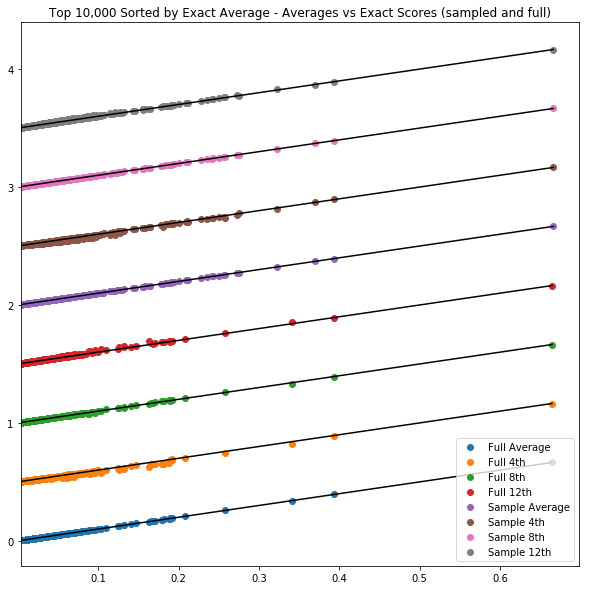

In [421]:
%matplotlib inline
scores_sorted = Q1_scores.sort_values(by='Average',ascending=True).tail(10000)[:-1]
offset = 0.5
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(111)
ax1.scatter(scores_sorted['Average'],scores_sorted['Average'],label='Full Average')
ax1.plot(scores_sorted['Average'],scores_sorted['Average'],c='black')
ax1.scatter(scores_sorted['Average'],scores_sorted['4']+1*offset,label='Full 4th')
ax1.plot(scores_sorted['Average'],scores_sorted['Average']+1*offset,c='black')
ax1.scatter(scores_sorted['Average'],scores_sorted['8']+2*offset,label='Full 8th')
ax1.plot(scores_sorted['Average'],scores_sorted['Average']+2*offset,c='black')
ax1.scatter(scores_sorted['Average'],scores_sorted['12']+3*offset,label='Full 12th')
ax1.plot(scores_sorted['Average'],scores_sorted['Average']+3*offset,c='black')
ax1.scatter(scores_sorted['sAverage'],scores_sorted['sAverage']+4*offset,label='Sample Average')
ax1.plot(scores_sorted['sAverage'],scores_sorted['sAverage']+4*offset,c='black')
ax1.scatter(scores_sorted['sAverage'],scores_sorted['s4']+5*offset,label='Sample 4th')
ax1.plot(scores_sorted['sAverage'],scores_sorted['sAverage']+5*offset,c='black')
ax1.scatter(scores_sorted['sAverage'],scores_sorted['s8']+6*offset,label='Sample 8th')
ax1.plot(scores_sorted['sAverage'],scores_sorted['sAverage']+6*offset,c='black')
ax1.scatter(scores_sorted['sAverage'],scores_sorted['s12']+7*offset,label='Sample 12th')
ax1.plot(scores_sorted['sAverage'],scores_sorted['sAverage']+7*offset,c='black')
ax1.set_title('Top 10,000 Sorted by Exact Average - Averages vs Exact Scores (sampled and full)')
ax1.set_xlim((scores_sorted['Average'].min(),1.05*scores_sorted['Average'].max()))
handles,labels=ax1.get_legend_handles_labels()
plt.legend(handles[8:],labels[8:])
plt.show()

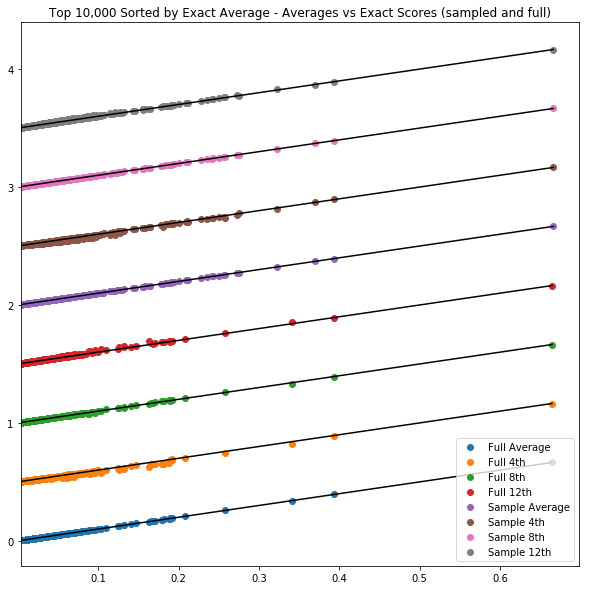

In [421]:
%matplotlib inline
scores_sorted = Q1_scores.sort_values(by='Average',ascending=True).tail(10000)[:-1]
offset = 0.5
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(111)
ax1.scatter(scores_sorted['Average'],scores_sorted['Average'],label='Full Average')
ax1.plot(scores_sorted['Average'],scores_sorted['Average'],c='black')
ax1.scatter(scores_sorted['Average'],scores_sorted['4']+1*offset,label='Full 4th')
ax1.plot(scores_sorted['Average'],scores_sorted['Average']+1*offset,c='black')
ax1.scatter(scores_sorted['Average'],scores_sorted['8']+2*offset,label='Full 8th')
ax1.plot(scores_sorted['Average'],scores_sorted['Average']+2*offset,c='black')
ax1.scatter(scores_sorted['Average'],scores_sorted['12']+3*offset,label='Full 12th')
ax1.plot(scores_sorted['Average'],scores_sorted['Average']+3*offset,c='black')
ax1.scatter(scores_sorted['sAverage'],scores_sorted['sAverage']+4*offset,label='Sample Average')
ax1.plot(scores_sorted['sAverage'],scores_sorted['sAverage']+4*offset,c='black')
ax1.scatter(scores_sorted['sAverage'],scores_sorted['s4']+5*offset,label='Sample 4th')
ax1.plot(scores_sorted['sAverage'],scores_sorted['sAverage']+5*offset,c='black')
ax1.scatter(scores_sorted['sAverage'],scores_sorted['s8']+6*offset,label='Sample 8th')
ax1.plot(scores_sorted['sAverage'],scores_sorted['sAverage']+6*offset,c='black')
ax1.scatter(scores_sorted['sAverage'],scores_sorted['s12']+7*offset,label='Sample 12th')
ax1.plot(scores_sorted['sAverage'],scores_sorted['sAverage']+7*offset,c='black')
ax1.set_title('Top 10,000 Sorted by Exact Average - Averages vs Exact Scores (sampled and full)')
ax1.set_xlim((scores_sorted['Average'].min(),1.05*scores_sorted['Average'].max()))
handles,labels=ax1.get_legend_handles_labels()
plt.legend(handles[8:],labels[8:])
plt.show()

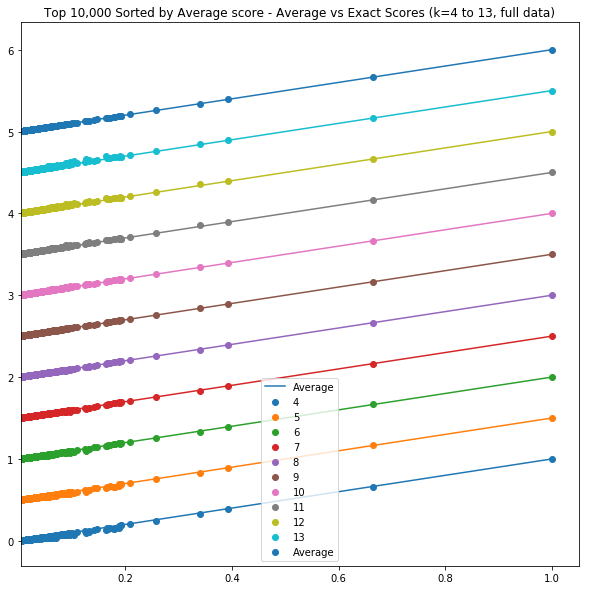

In [449]:
%matplotlib inline
scores_sorted = Q1_scores.sort_values(by='Average',ascending=True).tail(10000)
offset = 0.5
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(111)
sref = scores_sorted['Average']
for i in range(11):
    y = scores_sorted.iloc[:,i]
    label = y.name
    ax1.scatter(sref,y+i*offset,label=label)
    ax1.plot(sref,sref+i*offset)
ax1.set_title('Top 10,000 Sorted by Average score - Average vs Exact Scores (k=4 to 13, full data)')
ax1.set_xlim((scores_sorted['Average'].min(),1.05*scores_sorted['Average'].max()))
handles,labels=ax1.get_legend_handles_labels()
plt.legend(handles[10:],labels[10:])
plt.show()

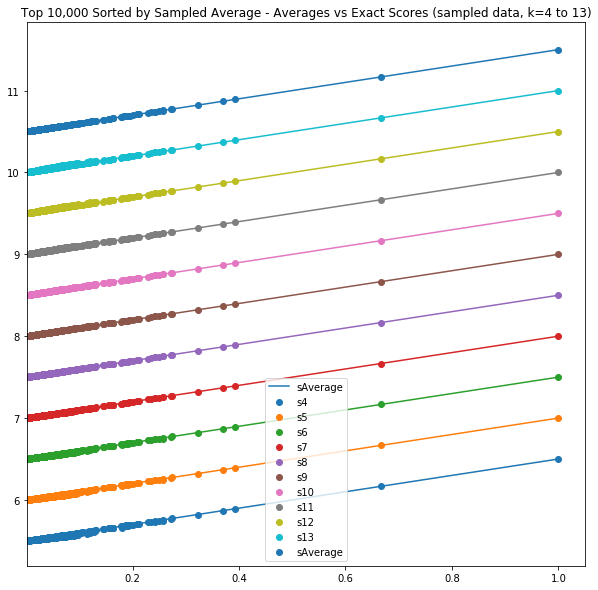

In [450]:
%matplotlib inline
scores_sorted = Q1_scores.sort_values(by='sAverage',ascending=True).tail(10000)
offset = 0.5
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(111)
sref = scores_sorted['sAverage']
for i in range(11,22):
    y = scores_sorted.iloc[:,i]
    label = y.name
    ax1.scatter(sref,y+i*offset,label=label)
    ax1.plot(sref,sref+i*offset)
ax1.set_title('Top 10,000 Sorted by Sampled Average - Averages vs Exact Scores (sampled data, k=4 to 13)')
ax1.set_xlim((scores_sorted['Average'].min(),1.05*scores_sorted['Average'].max()))
handles,labels=ax1.get_legend_handles_labels()
plt.legend(handles[10:],labels[10:])
plt.show()

Sampling inflates scores (later shown to be a result of looking at furuther neighbors)

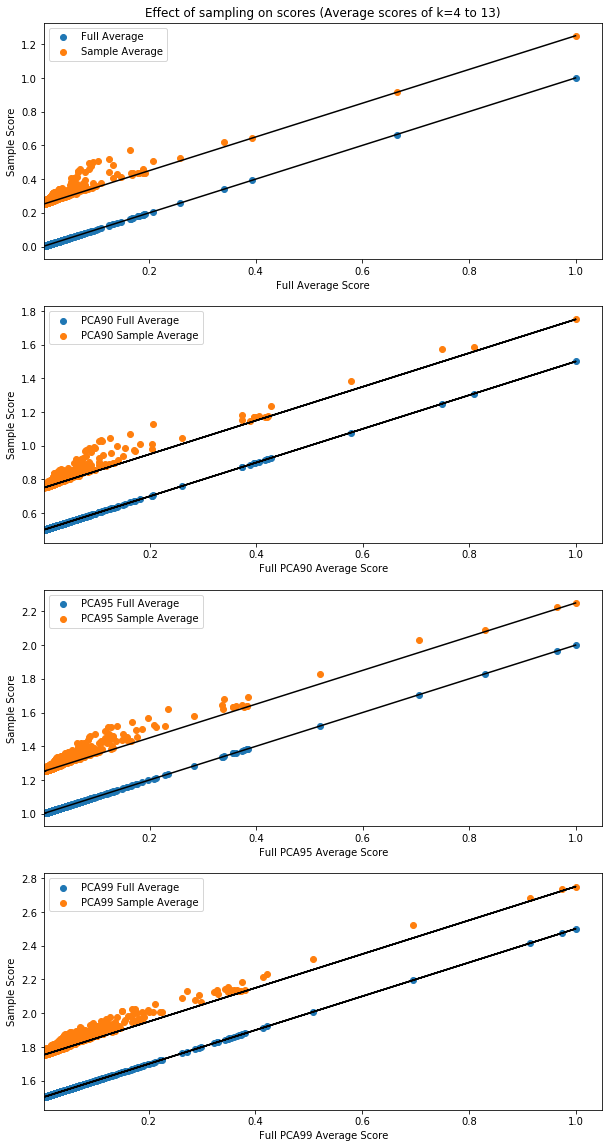

In [971]:
%matplotlib inline
scores_sorted =Q1_scores.sort_values(by='Average',ascending=True).tail(10000)
fig = plt.figure(figsize=(10,20))
ax1 = fig.add_subplot(411)
ax1.scatter(scores_sorted['Average'],scores_sorted['Average'],label='Full Average')
ax1.plot(scores_sorted['Average'],scores_sorted['Average'],c='black')
ax1.scatter(scores_sorted['Average'],scores_sorted['sAverage']+.25,label='Sample Average')
ax1.plot(scores_sorted['Average'],scores_sorted['Average']+.25,c='black')
ax1.set_xlabel('Full Average Score')
ax1.set_ylabel('Sample Score')
handles,labels=ax1.get_legend_handles_labels()
ax1.legend(handles[2:],labels[2:])

ax2 = fig.add_subplot(412)
ax2.scatter(scores_sorted['PCA90_Average'],scores_sorted['PCA90_Average']+.5,label='PCA90 Full Average')
ax2.plot(scores_sorted['PCA90_Average'],scores_sorted['PCA90_Average']+.5,c='black')
ax2.scatter(scores_sorted['PCA90_Average'],scores_sorted['PCA90_sAverage']+.75,label='PCA90 Sample Average')
ax2.plot(scores_sorted['PCA90_Average'],scores_sorted['PCA90_Average']+.75,c='black')
ax2.set_xlabel('Full PCA90 Average Score')
ax2.set_ylabel('Sample Score')
handles,labels=ax2.get_legend_handles_labels()
ax2.legend(handles[2:],labels[2:])

ax3 = fig.add_subplot(413)
ax3.scatter(scores_sorted['PCA95_Average'],scores_sorted['PCA95_Average']+1,label='PCA95 Full Average')
ax3.plot(scores_sorted['PCA95_Average'],scores_sorted['PCA95_Average']+1,c='black')
ax3.scatter(scores_sorted['PCA95_Average'],scores_sorted['PCA95_sAverage']+1.25,label='PCA95 Sample Average')
ax3.plot(scores_sorted['PCA95_Average'],scores_sorted['PCA95_Average']+1.25,c='black')
ax3.set_xlabel('Full PCA95 Average Score')
ax3.set_ylabel('Sample Score')
handles,labels=ax3.get_legend_handles_labels()
ax3.legend(handles[2:],labels[2:])

ax4 = fig.add_subplot(414)
ax4.scatter(scores_sorted['PCA99_Average'],scores_sorted['PCA99_Average']+1.5,label='PCA99 Full Average')
ax4.plot(scores_sorted['PCA99_Average'],scores_sorted['PCA99_Average']+1.5,c='black')
ax4.scatter(scores_sorted['PCA99_Average'],scores_sorted['PCA99_sAverage']+1.75,label='PCA99 Sample Average')
ax4.plot(scores_sorted['PCA99_Average'],scores_sorted['PCA99_Average']+1.75,c='black')
ax4.set_xlabel('Full PCA99 Average Score')
ax4.set_ylabel('Sample Score')
handles,labels=ax4.get_legend_handles_labels()
ax4.legend(handles[2:],labels[2:])

ax1.set_title('Effect of sampling on scores (Average scores of k=4 to 13)')
ax1.set_xlim((scores_sorted['Average'].min(),1.05*scores_sorted['Average'].max()))
ax2.set_xlim((scores_sorted['PCA90_Average'].min(),1.05*scores_sorted['PCA90_Average'].max()))
ax3.set_xlim((scores_sorted['PCA95_Average'].min(),1.05*scores_sorted['PCA95_Average'].max()))
ax4.set_xlim((scores_sorted['PCA99_Average'].min(),1.05*scores_sorted['PCA99_Average'].max()))
plt.show()

Nearest neighbors fluctuate much more than furhter neighbors.

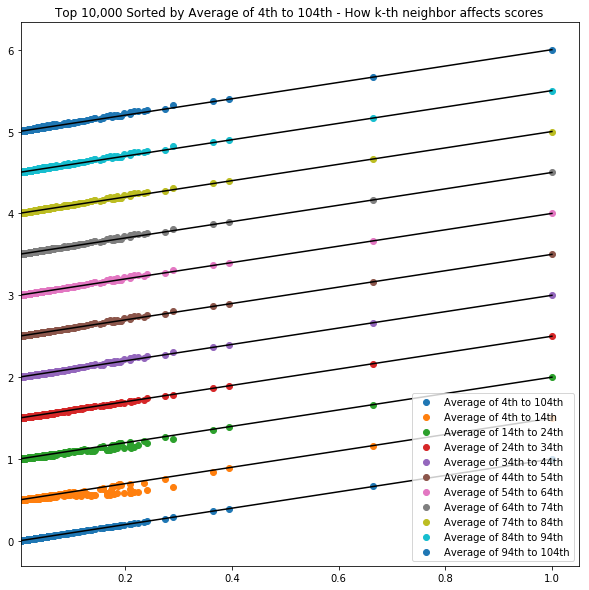

In [888]:
%matplotlib inline
scores_sorted = Q1_scores.sort_values(by='av_4_104',ascending=True).tail(10000)
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(111)
ax1.scatter(scores_sorted['av_4_104'],scores_sorted['av_4_104'],label='Average of 4th to 104th')
ax1.plot(scores_sorted['av_4_104'],scores_sorted['av_4_104'],c='black')
ax1.scatter(scores_sorted['av_4_104'],scores_sorted['av_4_14']+1*offset,label='Average of 4th to 14th')
ax1.plot(scores_sorted['av_4_104'],scores_sorted['av_4_104']+1*offset,c='black')
ax1.scatter(scores_sorted['av_4_104'],scores_sorted['av_14_24']+2*offset,label='Average of 14th to 24th')
ax1.plot(scores_sorted['av_4_104'],scores_sorted['av_4_104']+2*offset,c='black')
ax1.scatter(scores_sorted['av_4_104'],scores_sorted['av_24_34']+3*offset,label='Average of 24th to 34th')
ax1.plot(scores_sorted['av_4_104'],scores_sorted['av_4_104']+3*offset,c='black')
ax1.scatter(scores_sorted['av_4_104'],scores_sorted['av_34_44']+4*offset,label='Average of 34th to 44th')
ax1.plot(scores_sorted['av_4_104'],scores_sorted['av_4_104']+4*offset,c='black')
ax1.scatter(scores_sorted['av_4_104'],scores_sorted['av_44_54']+5*offset,label='Average of 44th to 54th')
ax1.plot(scores_sorted['av_4_104'],scores_sorted['av_4_104']+5*offset,c='black')
ax1.scatter(scores_sorted['av_4_104'],scores_sorted['av_54_64']+6*offset,label='Average of 54th to 64th')
ax1.plot(scores_sorted['av_4_104'],scores_sorted['av_4_104']+6*offset,c='black')
ax1.scatter(scores_sorted['av_4_104'],scores_sorted['av_64_74']+7*offset,label='Average of 64th to 74th')
ax1.plot(scores_sorted['av_4_104'],scores_sorted['av_4_104']+7*offset,c='black')
ax1.scatter(scores_sorted['av_4_104'],scores_sorted['av_74_84']+8*offset,label='Average of 74th to 84th')
ax1.plot(scores_sorted['av_4_104'],scores_sorted['av_4_104']+8*offset,c='black')
ax1.scatter(scores_sorted['av_4_104'],scores_sorted['av_84_94']+9*offset,label='Average of 84th to 94th')
ax1.plot(scores_sorted['av_4_104'],scores_sorted['av_4_104']+9*offset,c='black')
ax1.scatter(scores_sorted['av_4_104'],scores_sorted['av_94_10']+10*offset,label='Average of 94th to 104th')
ax1.plot(scores_sorted['av_4_104'],scores_sorted['av_4_104']+10*offset,c='black')

ax1.set_title('Top 10,000 Sorted by Average of 4th to 104th - How k-th neighbor affects scores')
ax1.set_xlim((scores_sorted['av_4_104'].min(),1.05*scores_sorted['av_4_104'].max()))
handles,labels=ax1.get_legend_handles_labels()
plt.legend(handles[11:],labels[11:])

plt.show()

Further neighbors produce similar results (beyond 300th neighbor), which aren't dramitically differnt from closer neighbors

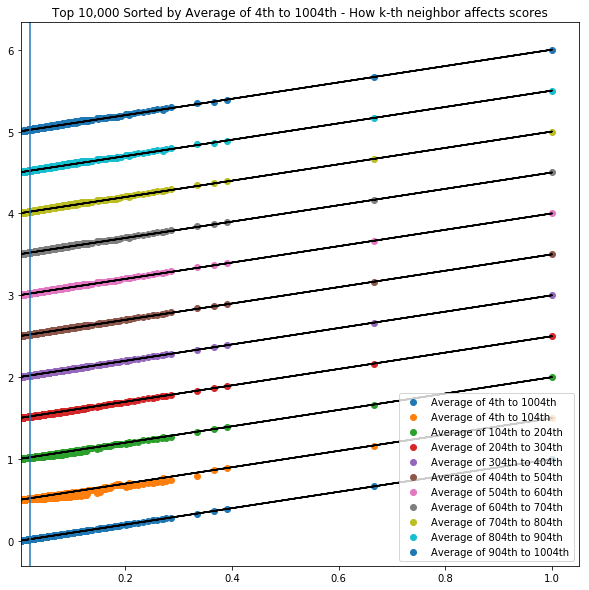

In [909]:
%matplotlib inline
scores_sorted = Q1_scores.sort_values(by='av_4_104',ascending=True).tail(10000)
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(111)
ax1.scatter(scores_sorted['av_4_1004'],scores_sorted['av_4_1004'],label='Average of 4th to 1004th')
ax1.plot(scores_sorted['av_4_1004'],scores_sorted['av_4_1004'],c='black')
ax1.scatter(scores_sorted['av_4_1004'],scores_sorted['av_4_104']+1*offset,label='Average of 4th to 104th')
ax1.plot(scores_sorted['av_4_1004'],scores_sorted['av_4_1004']+1*offset,c='black')
ax1.scatter(scores_sorted['av_4_1004'],scores_sorted['av_104_204']+2*offset,label='Average of 104th to 204th')
ax1.plot(scores_sorted['av_4_1004'],scores_sorted['av_4_1004']+2*offset,c='black')
ax1.scatter(scores_sorted['av_4_1004'],scores_sorted['av_204_304']+3*offset,label='Average of 204th to 304th')
ax1.plot(scores_sorted['av_4_1004'],scores_sorted['av_4_1004']+3*offset,c='black')
ax1.scatter(scores_sorted['av_4_1004'],scores_sorted['av_304_404']+4*offset,label='Average of 304th to 404th')
ax1.plot(scores_sorted['av_4_1004'],scores_sorted['av_4_1004']+4*offset,c='black')
ax1.scatter(scores_sorted['av_4_1004'],scores_sorted['av_404_504']+5*offset,label='Average of 404th to 504th')
ax1.plot(scores_sorted['av_4_1004'],scores_sorted['av_4_1004']+5*offset,c='black')
ax1.scatter(scores_sorted['av_4_1004'],scores_sorted['av_504_604']+6*offset,label='Average of 504th to 604th')
ax1.plot(scores_sorted['av_4_1004'],scores_sorted['av_4_1004']+6*offset,c='black')
ax1.scatter(scores_sorted['av_4_1004'],scores_sorted['av_604_704']+7*offset,label='Average of 604th to 704th')
ax1.plot(scores_sorted['av_4_1004'],scores_sorted['av_4_1004']+7*offset,c='black')
ax1.scatter(scores_sorted['av_4_1004'],scores_sorted['av_704_804']+8*offset,label='Average of 704th to 804th')
ax1.plot(scores_sorted['av_4_1004'],scores_sorted['av_4_1004']+8*offset,c='black')
ax1.scatter(scores_sorted['av_4_1004'],scores_sorted['av_804_904']+9*offset,label='Average of 804th to 904th')
ax1.plot(scores_sorted['av_4_1004'],scores_sorted['av_4_1004']+9*offset,c='black')
ax1.scatter(scores_sorted['av_4_1004'],scores_sorted['av_904_1004']+10*offset,label='Average of 904th to 1004th')
ax1.plot(scores_sorted['av_4_1004'],scores_sorted['av_4_1004']+10*offset,c='black')

ax1.set_title('Top 10,000 Sorted by Average of 4th to 1004th - How k-th neighbor affects scores')
ax1.set_xlim((scores_sorted['av_4_104'].min(),1.05*scores_sorted['av_4_104'].max()))
handles,labels=ax1.get_legend_handles_labels()
plt.legend(handles[11:],labels[11:])
plt.axvline(scores_sorted.tail(1000)['av_s4_104'][0])
plt.show()

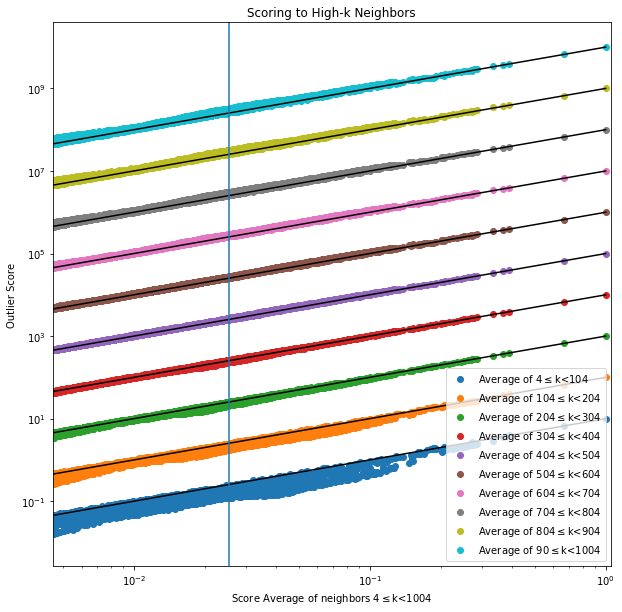

In [935]:
%matplotlib inline
scores_sorted = Q1_scores.sort_values(by='av_4_1004',ascending=True).tail(10000)
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(111)

ax1.scatter(scores_sorted['av_4_1004'],scores_sorted['av_4_104']*1E1,label='Average of 4$\leq$k<104')
ax1.plot(scores_sorted['av_4_1004'],scores_sorted['av_4_1004']*1E1,c='black')
ax1.scatter(scores_sorted['av_4_1004'],scores_sorted['av_104_204']*1E2,label='Average of 104$\leq$k<204')
ax1.plot(scores_sorted['av_4_1004'],scores_sorted['av_4_1004']*1E2,c='black')
ax1.scatter(scores_sorted['av_4_1004'],scores_sorted['av_204_304']*1E3,label='Average of 204$\leq$k<304')
ax1.plot(scores_sorted['av_4_1004'],scores_sorted['av_4_1004']*1E3,c='black')
ax1.scatter(scores_sorted['av_4_1004'],scores_sorted['av_304_404']*1E4,label='Average of 304$\leq$k<404')
ax1.plot(scores_sorted['av_4_1004'],scores_sorted['av_4_1004']*1E4,c='black')
ax1.scatter(scores_sorted['av_4_1004'],scores_sorted['av_404_504']*1E5,label='Average of 404$\leq$k<504')
ax1.plot(scores_sorted['av_4_1004'],scores_sorted['av_4_1004']*1E5,c='black')
ax1.scatter(scores_sorted['av_4_1004'],scores_sorted['av_504_604']*1E6,label='Average of 504$\leq$k<604')
ax1.plot(scores_sorted['av_4_1004'],scores_sorted['av_4_1004']*1E6,c='black')
ax1.scatter(scores_sorted['av_4_1004'],scores_sorted['av_604_704']*1E7,label='Average of 604$\leq$k<704')
ax1.plot(scores_sorted['av_4_1004'],scores_sorted['av_4_1004']*1E7,c='black')
ax1.scatter(scores_sorted['av_4_1004'],scores_sorted['av_704_804']*1E8,label='Average of 704$\leq$k<804')
ax1.plot(scores_sorted['av_4_1004'],scores_sorted['av_4_1004']*1E8,c='black')
ax1.scatter(scores_sorted['av_4_1004'],scores_sorted['av_804_904']*1E9,label='Average of 804$\leq$k<904')
ax1.plot(scores_sorted['av_4_1004'],scores_sorted['av_4_1004']*1E9,c='black')
ax1.scatter(scores_sorted['av_4_1004'],scores_sorted['av_904_1004']*1E10,label='Average of 90$\leq$k<1004')
ax1.plot(scores_sorted['av_4_1004'],scores_sorted['av_4_1004']*1E10,c='black')

ax1.set_title('Scoring to High-k Neighbors')
ax1.set_xlim((scores_sorted['av_4_1004'].min(),1.05*scores_sorted['av_4_1004'].max()))
plt.ylabel('Outlier Score')
plt.xlabel('Score Average of neighbors 4$\leq$k<1004')
plt.xscale('log')
plt.yscale('log')
handles,labels=ax1.get_legend_handles_labels()
plt.legend(handles[10:],labels[10:])
plt.axvline(scores_sorted.tail(1000)['av_4_1004'][0])
plt.show()

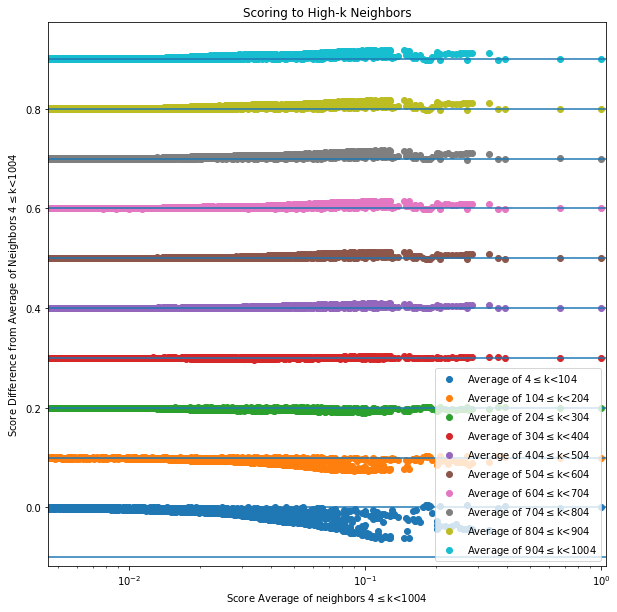

In [958]:
%matplotlib inline
scores_sorted = Q1_scores.sort_values(by='av_4_1004',ascending=True).tail(10000)
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(111)

ax1.scatter(scores_sorted['av_4_1004'],(scores_sorted['av_4_104']-scores_sorted['av_4_1004']),label='Average of 4$\leq$k<104')
ax1.scatter(scores_sorted['av_4_1004'],(scores_sorted['av_104_204']-scores_sorted['av_4_1004'])+.1,label='Average of 104$\leq$k<204')
ax1.scatter(scores_sorted['av_4_1004'],(scores_sorted['av_204_304']-scores_sorted['av_4_1004'])+.2,label='Average of 204$\leq$k<304')
ax1.scatter(scores_sorted['av_4_1004'],(scores_sorted['av_304_404']-scores_sorted['av_4_1004'])+.3,label='Average of 304$\leq$k<404')
ax1.scatter(scores_sorted['av_4_1004'],(scores_sorted['av_404_504']-scores_sorted['av_4_1004'])+.4,label='Average of 404$\leq$k<504')
ax1.scatter(scores_sorted['av_4_1004'],(scores_sorted['av_504_604']-scores_sorted['av_4_1004'])+.5,label='Average of 504$\leq$k<604')
ax1.scatter(scores_sorted['av_4_1004'],(scores_sorted['av_604_704']-scores_sorted['av_4_1004'])+.6,label='Average of 604$\leq$k<704')
ax1.scatter(scores_sorted['av_4_1004'],(scores_sorted['av_704_804']-scores_sorted['av_4_1004'])+.7,label='Average of 704$\leq$k<804')
ax1.scatter(scores_sorted['av_4_1004'],(scores_sorted['av_804_904']-scores_sorted['av_4_1004'])+.8,label='Average of 804$\leq$k<904')
ax1.scatter(scores_sorted['av_4_1004'],(scores_sorted['av_904_1004']-scores_sorted['av_4_1004'])+.9,label='Average of 904$\leq$k<1004')


ax1.set_title('Scoring to High-k Neighbors')
ax1.set_xlim((scores_sorted['av_4_1004'].min(),1.05*scores_sorted['av_4_1004'].max()))
plt.ylabel('Score Difference from Average of Neighbors 4$\leq$k<1004')
plt.xlabel('Score Average of neighbors 4$\leq$k<1004')
plt.xscale('log')
#plt.yscale('log')
for h in range(-1,10,1):
    plt.axhline(h/10)
handles,labels=ax1.get_legend_handles_labels()
plt.legend()
plt.axvline(scores_sorted.tail(1000)['av_4_1004'][0])

plt.show()

Low neighber sampled data strongly resembles high neighbors from the full data. Sampling 1k neighbors decreases density by a factor of ~150. The distance to the 4th nearest neighbor in the sample represents the distance to ~600th nearest neighbor in the full dataset.

Increasing the sample average to include more neighbors (4th to 14th vs 4th to 104th) does not significantly impact the sampled scores.

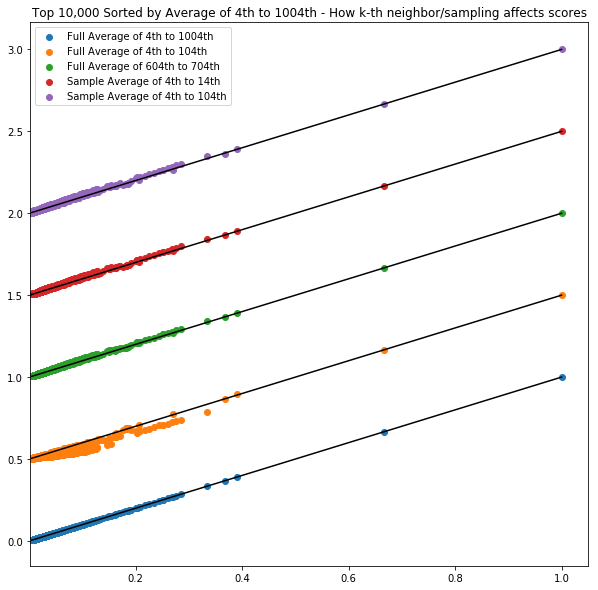

In [422]:
%matplotlib inline
scores_sorted = Q1_scores.sort_values(by='av_4_1004',ascending=True).tail(10000)
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(111)
ax1.scatter(scores_sorted['av_4_1004'],scores_sorted['av_4_1004'],label='Full Average of 4th to 1004th')
ax1.plot(scores_sorted['av_4_1004'],scores_sorted['av_4_1004'],c='black')
ax1.scatter(scores_sorted['av_4_1004'],scores_sorted['av_4_104']+1*offset,label='Full Average of 4th to 104th')
ax1.plot(scores_sorted['av_4_1004'],scores_sorted['av_4_1004']+1*offset,c='black')
ax1.scatter(scores_sorted['av_4_1004'],scores_sorted['av_604_704']+2*offset,label='Full Average of 604th to 704th')
ax1.plot(scores_sorted['av_4_1004'],scores_sorted['av_4_1004']+2*offset,c='black')
ax1.scatter(scores_sorted['av_4_1004'],scores_sorted['av_s4_14']+3*offset,label='Sample Average of 4th to 14th')
ax1.plot(scores_sorted['av_4_104'],scores_sorted['av_4_104']+3*offset,c='black')
ax1.scatter(scores_sorted['av_4_1004'],scores_sorted['av_s4_104']+4*offset,label='Sample Average of 4th to 104th')
ax1.plot(scores_sorted['av_4_1004'],scores_sorted['av_4_1004']+4*offset,c='black')



ax1.set_title('Top 10,000 Sorted by Average of 4th to 1004th - How k-th neighbor/sampling affects scores')
ax1.set_xlim((scores_sorted['av_4_104'].min(),1.05*scores_sorted['av_4_104'].max()))
handles,labels=ax1.get_legend_handles_labels()
plt.legend(handles[5:],labels[5:])
plt.show()

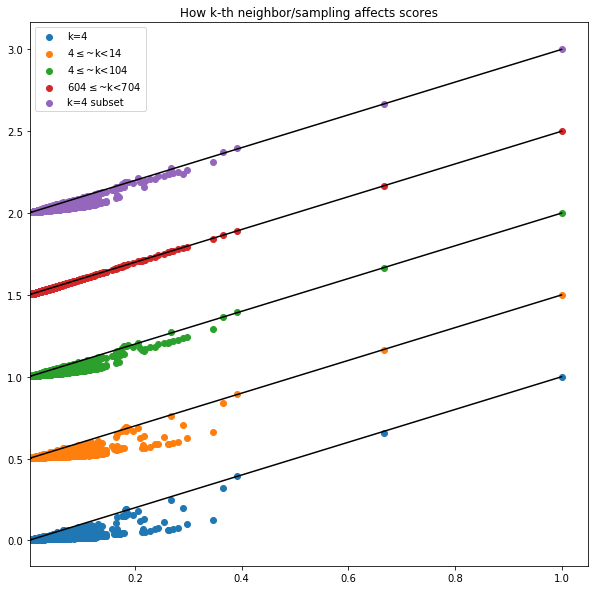

In [967]:
%matplotlib inline
scores_sorted = Q1_scores.sort_values(by='s4',ascending=True).tail(10000)
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(111)

ax1.scatter(scores_sorted['av_s4_14'],scores_sorted['4'],label='k=4')
ax1.plot(scores_sorted['av_s4_14'],scores_sorted['av_s4_14'],c='black')
ax1.scatter(scores_sorted['av_s4_14'],scores_sorted['av_4_14']+1*offset,label='4$\leq$~k<14')
ax1.plot(scores_sorted['av_s4_14'],scores_sorted['av_s4_14']+1*offset,c='black')
ax1.scatter(scores_sorted['av_s4_14'],scores_sorted['av_4_104']+2*offset,label='4$\leq$~k<104')
ax1.plot(scores_sorted['av_s4_14'],scores_sorted['av_s4_14']+2*offset,c='black')
ax1.scatter(scores_sorted['av_s4_14'],scores_sorted['av_604_704']+3*offset,label='604$\leq$~k<704')
ax1.plot(scores_sorted['av_s4_14'],scores_sorted['av_s4_14']+3*offset,c='black')
ax1.scatter(scores_sorted['av_s4_14'],scores_sorted['s4']+4*offset,label='k=4 subset')
ax1.plot(scores_sorted['av_s4_14'],scores_sorted['av_s4_14']+4*offset,c='black')


ax1.set_title('How k-th neighbor/sampling affects scores')
ax1.set_xlim((scores_sorted['av_4_104'].min(),1.05*scores_sorted['av_4_104'].max()))
handles,labels=ax1.get_legend_handles_labels()
plt.legend(handles[5:],labels[5:])
plt.show()

For the full data, the average score for lower neighbors (4th to 14th, 14th to 24th) has much more variance than the average scores for higher neighbors. Specifically, scoring by closer neighbors tends to result in lower scores below ~0.4 as averaged over 4th to 104th neighbors.

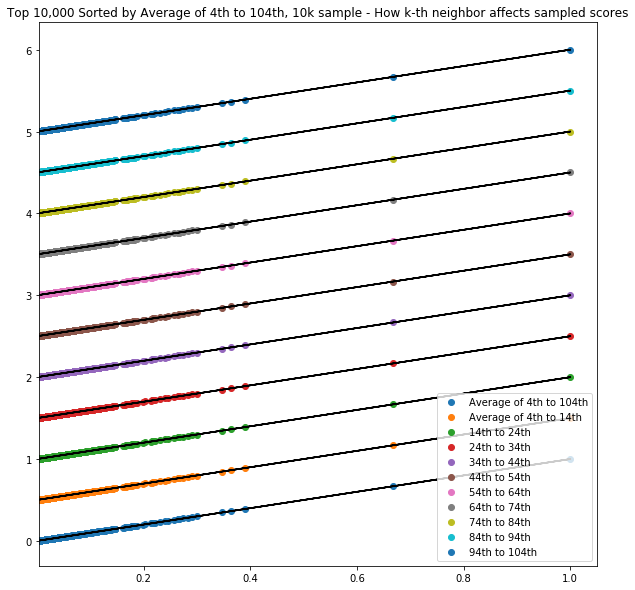

In [877]:
%matplotlib inline
scores_sorted = Q1_scores.sort_values(by='av_4_104',ascending=True).tail(10000)
offset=0.5
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(111)
ax1.scatter(scores_sorted['av_s4_104'],scores_sorted['av_s4_104'],label='Average of 4th to 104th')
ax1.plot(scores_sorted['av_s4_104'],scores_sorted['av_s4_104'],c='black')
ax1.scatter(scores_sorted['av_s4_104'],scores_sorted['av_s4_14']+1*offset,label='Average of 4th to 14th')
ax1.plot(scores_sorted['av_s4_104'],scores_sorted['av_s4_104']+1*offset,c='black')
ax1.scatter(scores_sorted['av_s4_104'],scores_sorted['av_s14_24']+2*offset,label='14th to 24th')
ax1.plot(scores_sorted['av_s4_104'],scores_sorted['av_s4_104']+2*offset,c='black')
ax1.scatter(scores_sorted['av_s4_104'],scores_sorted['av_s24_34']+3*offset,label='24th to 34th')
ax1.plot(scores_sorted['av_s4_104'],scores_sorted['av_s4_104']+3*offset,c='black')
ax1.scatter(scores_sorted['av_s4_104'],scores_sorted['av_s34_44']+4*offset,label='34th to 44th')
ax1.plot(scores_sorted['av_s4_104'],scores_sorted['av_s4_104']+4*offset,c='black')
ax1.scatter(scores_sorted['av_s4_104'],scores_sorted['av_s44_54']+5*offset,label='44th to 54th')
ax1.plot(scores_sorted['av_s4_104'],scores_sorted['av_s4_104']+5*offset,c='black')
ax1.scatter(scores_sorted['av_s4_104'],scores_sorted['av_s54_64']+6*offset,label='54th to 64th')
ax1.plot(scores_sorted['av_s4_104'],scores_sorted['av_s4_104']+6*offset,c='black')
ax1.scatter(scores_sorted['av_s4_104'],scores_sorted['av_s64_74']+7*offset,label='64th to 74th')
ax1.plot(scores_sorted['av_s4_104'],scores_sorted['av_s4_104']+7*offset,c='black')
ax1.scatter(scores_sorted['av_s4_104'],scores_sorted['av_s74_84']+8*offset,label='74th to 84th')
ax1.plot(scores_sorted['av_s4_104'],scores_sorted['av_s4_104']+8*offset,c='black')
ax1.scatter(scores_sorted['av_s4_104'],scores_sorted['av_s84_94']+9*offset,label='84th to 94th')
ax1.plot(scores_sorted['av_s4_104'],scores_sorted['av_s4_104']+9*offset,c='black')
ax1.scatter(scores_sorted['av_s4_104'],scores_sorted['av_s94_10']+10*offset,label='94th to 104th')
ax1.plot(scores_sorted['av_s4_104'],scores_sorted['av_s4_104']+10*offset,c='black')

ax1.set_title('Top 10,000 Sorted by Average of 4th to 104th, 10k sample - How k-th neighbor affects sampled scores')
ax1.set_xlim((scores_sorted['av_4_104'].min(),1.05*scores_sorted['av_4_104'].max()))
handles,labels=ax1.get_legend_handles_labels()
plt.legend(handles[11:],labels[11:])
plt.show()

#### PCA Increases scores, affecting middle scores the most

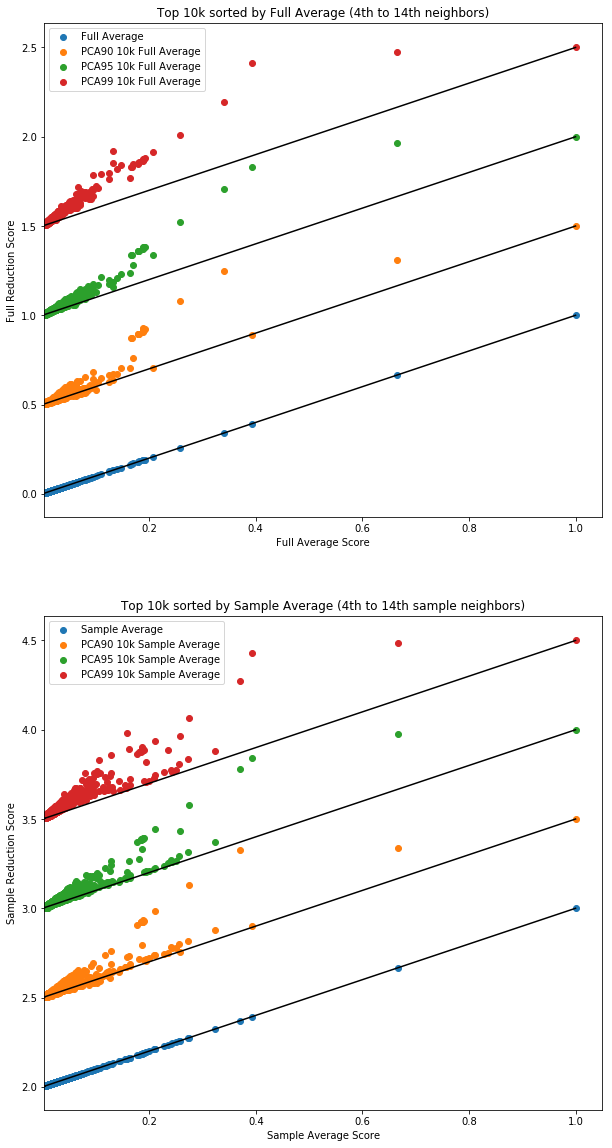

In [454]:
scores_sorted = Q1_scores.sort_values(by='Average',ascending=True).tail(10000)
offset=1/2
fig = plt.figure(figsize=(10,20))
ax1 = fig.add_subplot(211)
ax1.scatter(scores_sorted['Average'],scores_sorted['Average']+0*offset,label='Full Average')
ax1.plot(scores_sorted['Average'],scores_sorted['Average']+0*offset,c='black')
ax1.scatter(scores_sorted['Average'],scores_sorted['PCA90_Average']+1*offset,label='PCA90 10k Full Average')
ax1.plot(scores_sorted['Average'],scores_sorted['Average']+1*offset,c='black')
ax1.scatter(scores_sorted['Average'],scores_sorted['PCA95_Average']+2*offset,label='PCA95 10k Full Average')
ax1.plot(scores_sorted['Average'],scores_sorted['Average']+2*offset,c='black')
ax1.scatter(scores_sorted['Average'],scores_sorted['PCA99_Average']+3*offset,label='PCA99 10k Full Average')
ax1.plot(scores_sorted['Average'],scores_sorted['Average']+3*offset,c='black')
ax1.set_title('Top 10k sorted by Full Average (4th to 14th neighbors)')
ax1.set_xlabel('Full Average Score')
ax1.set_ylabel('Full Reduction Score')

ax2 = fig.add_subplot(212)
ax2.scatter(scores_sorted['sAverage'],scores_sorted['sAverage']+4*offset,label='Sample Average')
ax2.plot(scores_sorted['sAverage'],scores_sorted['sAverage']+4*offset,c='black')
ax2.scatter(scores_sorted['sAverage'],scores_sorted['PCA90_sAverage']+5*offset,label='PCA90 10k Sample Average')
ax2.plot(scores_sorted['sAverage'],scores_sorted['sAverage']+5*offset,c='black')
ax2.scatter(scores_sorted['sAverage'],scores_sorted['PCA95_sAverage']+6*offset,label='PCA95 10k Sample Average')
ax2.plot(scores_sorted['sAverage'],scores_sorted['sAverage']+6*offset,c='black')
ax2.scatter(scores_sorted['sAverage'],scores_sorted['PCA99_sAverage']+7*offset,label='PCA99 10k Sample Average')
ax2.plot(scores_sorted['sAverage'],scores_sorted['sAverage']+7*offset,c='black')
ax2.set_title('Top 10k sorted by Sample Average (4th to 14th sample neighbors)')
ax2.set_xlabel('Sample Average Score')
ax2.set_ylabel('Sample Reduction Score')

ax1.set_xlim((scores_sorted['Average'].min(),1.05*scores_sorted['Average'].max()))
ax2.set_xlim((scores_sorted['sAverage'].min(),1.05*scores_sorted['sAverage'].max()))

handles,labels=ax1.get_legend_handles_labels()
ax1.legend(handles[4:],labels[4:])
handles,labels=ax2.get_legend_handles_labels()
ax2.legend(handles[4:],labels[4:])
plt.show()

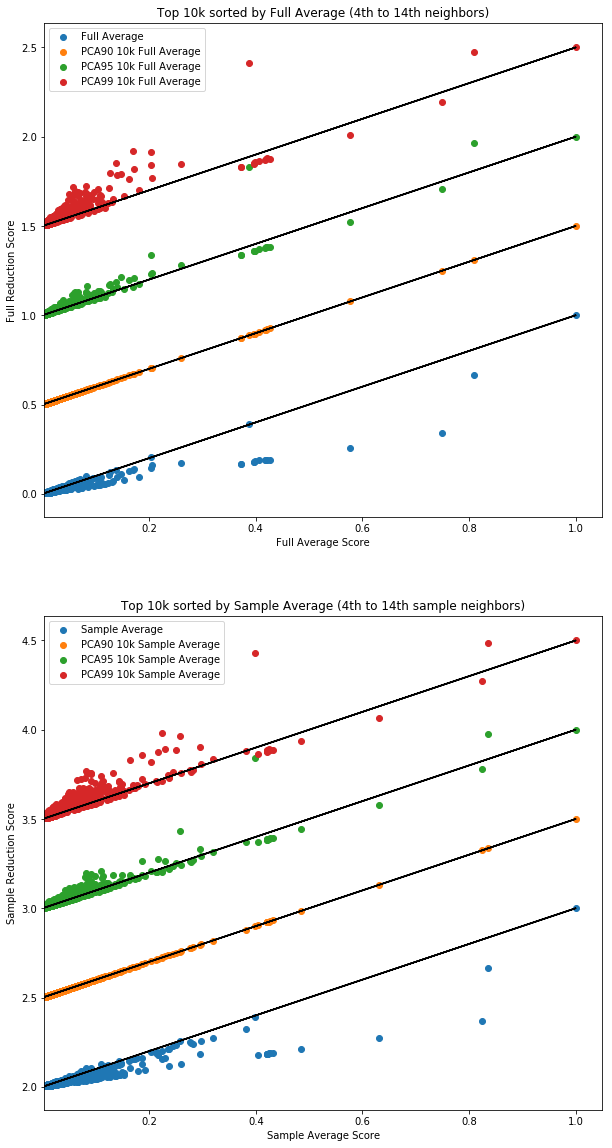

In [988]:
scores_sorted = Q1_scores.sort_values(by='Average',ascending=True).tail(10000)
offset=1/2
fig = plt.figure(figsize=(10,20))
ax1 = fig.add_subplot(211)
ax1.scatter(scores_sorted['PCA90_Average'],scores_sorted['Average']+0*offset,label='Full Average')
ax1.plot(scores_sorted['PCA90_Average'],scores_sorted['PCA90_Average']+0*offset,c='black')
ax1.scatter(scores_sorted['PCA90_Average'],scores_sorted['PCA90_Average']+1*offset,label='PCA90 10k Full Average')
ax1.plot(scores_sorted['PCA90_Average'],scores_sorted['PCA90_Average']+1*offset,c='black')
ax1.scatter(scores_sorted['PCA90_Average'],scores_sorted['PCA95_Average']+2*offset,label='PCA95 10k Full Average')
ax1.plot(scores_sorted['PCA90_Average'],scores_sorted['PCA90_Average']+2*offset,c='black')
ax1.scatter(scores_sorted['PCA90_Average'],scores_sorted['PCA99_Average']+3*offset,label='PCA99 10k Full Average')
ax1.plot(scores_sorted['PCA90_Average'],scores_sorted['PCA90_Average']+3*offset,c='black')
ax1.set_title('Top 10k sorted by Full Average (4th to 14th neighbors)')
ax1.set_xlabel('Full Average Score')
ax1.set_ylabel('Full Reduction Score')

ax2 = fig.add_subplot(212)
ax2.scatter(scores_sorted['PCA90_sAverage'],scores_sorted['sAverage']+4*offset,label='Sample Average')
ax2.plot(scores_sorted['PCA90_sAverage'],scores_sorted['PCA90_sAverage']+4*offset,c='black')
ax2.scatter(scores_sorted['PCA90_sAverage'],scores_sorted['PCA90_sAverage']+5*offset,label='PCA90 10k Sample Average')
ax2.plot(scores_sorted['PCA90_sAverage'],scores_sorted['PCA90_sAverage']+5*offset,c='black')
ax2.scatter(scores_sorted['PCA90_sAverage'],scores_sorted['PCA95_sAverage']+6*offset,label='PCA95 10k Sample Average')
ax2.plot(scores_sorted['PCA90_sAverage'],scores_sorted['PCA90_sAverage']+6*offset,c='black')
ax2.scatter(scores_sorted['PCA90_sAverage'],scores_sorted['PCA99_sAverage']+7*offset,label='PCA99 10k Sample Average')
ax2.plot(scores_sorted['PCA90_sAverage'],scores_sorted['PCA90_sAverage']+7*offset,c='black')
ax2.set_title('Top 10k sorted by Sample Average (4th to 14th sample neighbors)')
ax2.set_xlabel('Sample Average Score')
ax2.set_ylabel('Sample Reduction Score')

ax1.set_xlim((scores_sorted['Average'].min(),1.05*scores_sorted['Average'].max()))
ax2.set_xlim((scores_sorted['sAverage'].min(),1.05*scores_sorted['sAverage'].max()))

handles,labels=ax1.get_legend_handles_labels()
ax1.legend(handles[4:],labels[4:])
handles,labels=ax2.get_legend_handles_labels()
ax2.legend(handles[4:],labels[4:])
plt.show()

Size of sample and number of iterations don't affect scoring much.

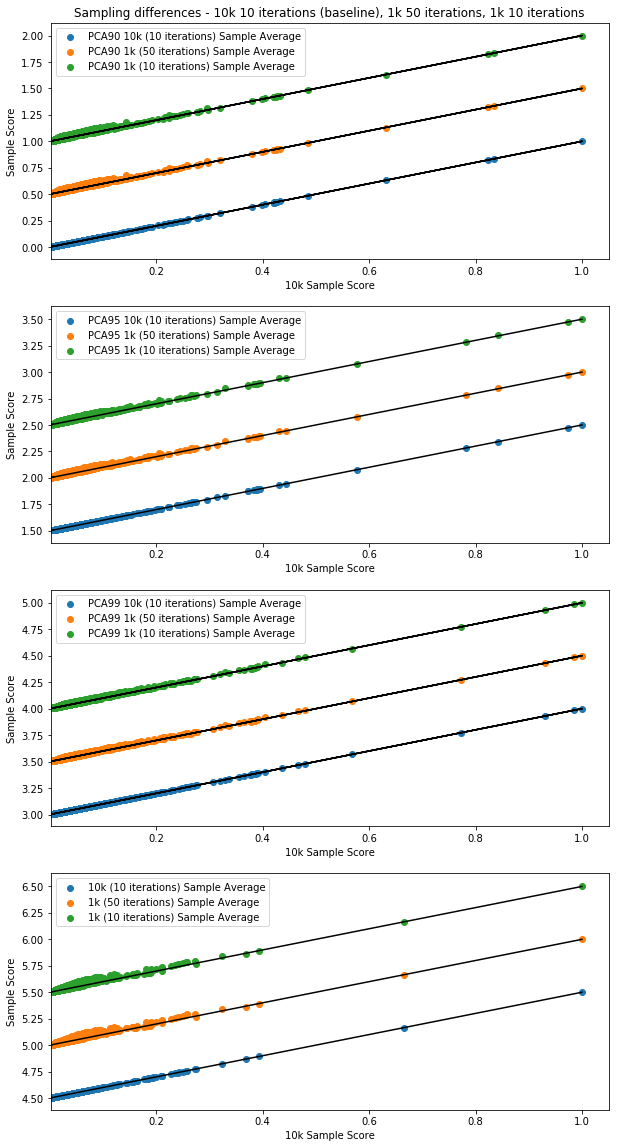

In [471]:
%matplotlib inline
scores_sorted = Q1_scores.sort_values(by='Average',ascending=True).tail(10000)
plotby = 'PCA90_sAverage'
offset=1/2
fig = plt.figure(figsize=(10,20))
ax1 = fig.add_subplot(411)
ax1.scatter(scores_sorted['PCA90_sAverage'],scores_sorted['PCA90_sAverage']+0*offset,label='PCA90 10k (10 iterations) Sample Average')
ax1.plot(scores_sorted['PCA90_sAverage'],scores_sorted['PCA90_sAverage']+0*offset,c='black')
ax1.scatter(scores_sorted['PCA90_sAverage'],scores_sorted['PCA90_s2Average']+1*offset,label='PCA90 1k (50 iterations) Sample Average')
ax1.plot(scores_sorted['PCA90_sAverage'],scores_sorted['PCA90_sAverage']+1*offset,c='black')
ax1.scatter(scores_sorted['PCA90_sAverage'],scores_sorted['PCA90_s3Average']+2*offset,label='PCA90 1k (10 iterations) Sample Average')
ax1.plot(scores_sorted['PCA90_sAverage'],scores_sorted['PCA90_sAverage']+2*offset,c='black')
ax2 = fig.add_subplot(412)
ax2.scatter(scores_sorted['PCA95_sAverage'],scores_sorted['PCA95_sAverage']+3*offset,label='PCA95 10k (10 iterations) Sample Average')
ax2.plot(scores_sorted['PCA95_sAverage'],scores_sorted['PCA95_sAverage']+3*offset,c='black')
ax2.scatter(scores_sorted['PCA95_sAverage'],scores_sorted['PCA95_s2Average']+4*offset,label='PCA95 1k (50 iterations) Sample Average')
ax2.plot(scores_sorted['PCA95_sAverage'],scores_sorted['PCA95_sAverage']+4*offset,c='black')
ax2.scatter(scores_sorted['PCA95_sAverage'],scores_sorted['PCA95_s3Average']+5*offset,label='PCA95 1k (10 iterations) Sample Average')
ax2.plot(scores_sorted['PCA95_sAverage'],scores_sorted['PCA95_sAverage']+5*offset,c='black')
ax3 = fig.add_subplot(413)
ax3.scatter(scores_sorted['PCA99_sAverage'],scores_sorted['PCA99_sAverage']+6*offset,label='PCA99 10k (10 iterations) Sample Average')
ax3.plot(scores_sorted['PCA99_sAverage'],scores_sorted['PCA99_sAverage']+6*offset,c='black')
ax3.scatter(scores_sorted['PCA99_sAverage'],scores_sorted['PCA99_s2Average']+7*offset,label='PCA99 1k (50 iterations) Sample Average')
ax3.plot(scores_sorted['PCA99_sAverage'],scores_sorted['PCA99_sAverage']+7*offset,c='black')
ax3.scatter(scores_sorted['PCA99_sAverage'],scores_sorted['PCA99_s3Average']+8*offset,label='PCA99 1k (10 iterations) Sample Average')
ax3.plot(scores_sorted['PCA99_sAverage'],scores_sorted['PCA99_sAverage']+8*offset,c='black')
ax4 = fig.add_subplot(414)
ax4.scatter(scores_sorted['sAverage'],scores_sorted['sAverage']+9*offset,label='10k (10 iterations) Sample Average')
ax4.plot(scores_sorted['sAverage'],scores_sorted['sAverage']+9*offset,c='black')
ax4.scatter(scores_sorted['sAverage'],scores_sorted['s2Average']+10*offset,label='1k (50 iterations) Sample Average')
ax4.plot(scores_sorted['sAverage'],scores_sorted['sAverage']+10*offset,c='black')
ax4.scatter(scores_sorted['sAverage'],scores_sorted['s3Average']+11*offset,label='1k (10 iterations) Sample Average')
ax4.plot(scores_sorted['sAverage'],scores_sorted['sAverage']+11*offset,c='black')

ax1.set_title('Sampling differences - 10k 10 iterations (baseline), 1k 50 iterations, 1k 10 iterations')


for ax in [ax1,ax2,ax3,ax4]:
    ax.set_xlabel('10k Sample Score')
    ax.set_ylabel('Sample Score')
    ax.set_xlim((scores_sorted[plotby].min(),1.05*scores_sorted[plotby].max()))
    handles,labels=ax.get_legend_handles_labels()
    ax.legend(handles[3:],labels[3:])

plt.show()

The scores of objects are relatively stable and trends are consistent, but the relative rank of each object is not nearly as stable outside of the most couple thousand most outlying points. The most outlying points, however, are the points of greatest interest. The relative ranks of clustered objects are not of particular interest to this work. The most variant ones, however, may merit some additional scrutiny, it's on the back burner for now.

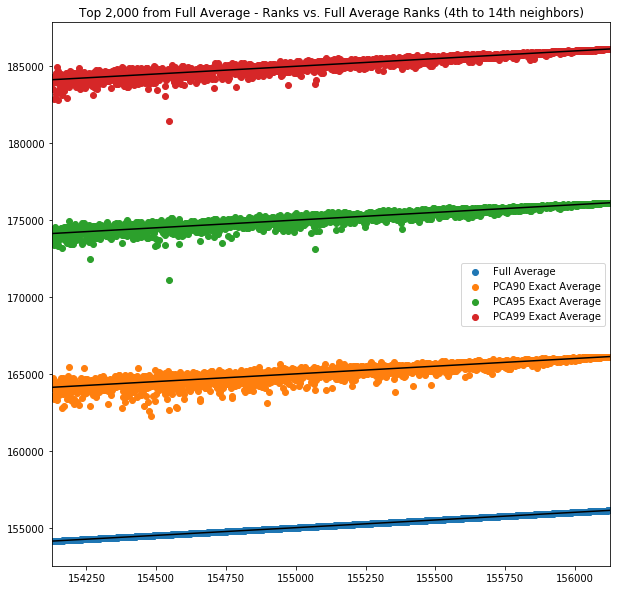

In [498]:
%matplotlib inline
scores_sorted = Q1_scores.rank(ascending=True).sort_values(by='Average').tail(2000)
plotby = 'Average'
offset=10000
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(111)
ax1.scatter(scores_sorted[plotby],scores_sorted['Average'],label='Full Average')
ax1.plot(scores_sorted[plotby],scores_sorted[plotby],c='black')
ax1.scatter(scores_sorted[plotby],scores_sorted['PCA90_Average']+1*offset,label='PCA90 Exact Average')
ax1.plot(scores_sorted[plotby],scores_sorted[plotby]+1*offset,c='black')
ax1.scatter(scores_sorted[plotby],scores_sorted['PCA95_Average']+2*offset,label='PCA95 Exact Average')
ax1.plot(scores_sorted[plotby],scores_sorted[plotby]+2*offset,c='black')
ax1.scatter(scores_sorted[plotby],scores_sorted['PCA99_Average']+3*offset,label='PCA99 Exact Average')
ax1.plot(scores_sorted[plotby],scores_sorted[plotby]+3*offset,c='black')
ax1.set_title('Top 2,000 from Full Average - Ranks vs. Full Average Ranks (4th to 14th neighbors)')
ax1.set_xlim((scores_sorted[plotby].min(),scores_sorted[plotby].max()))
handles,labels=ax1.get_legend_handles_labels()
ax1.legend(handles[4:],labels[4:])

plt.show()

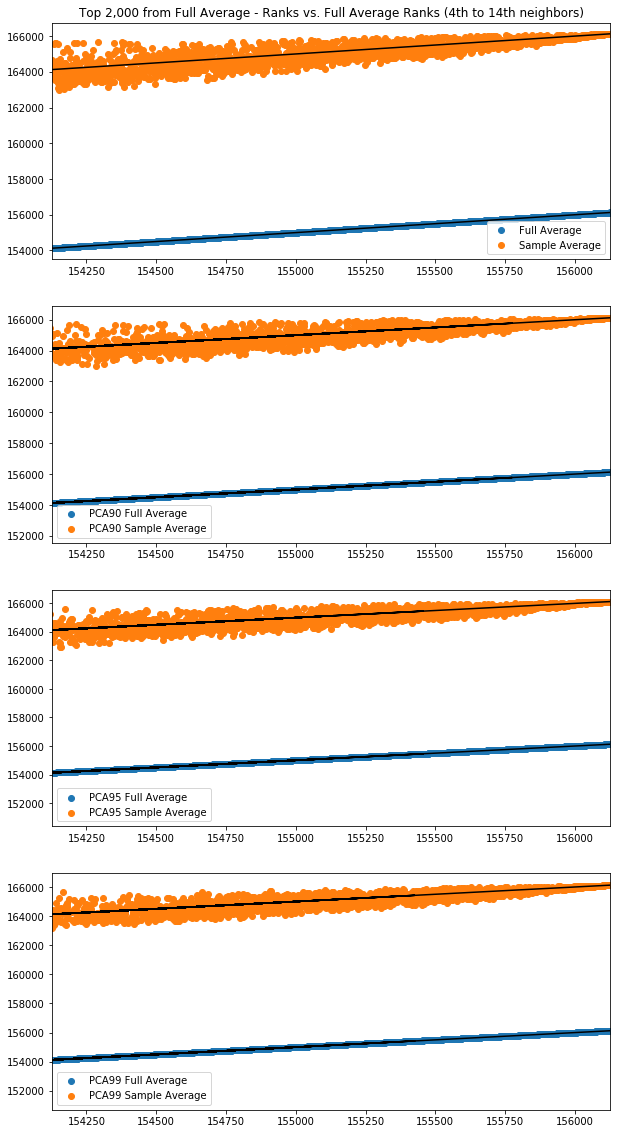

In [504]:
%matplotlib inline
scores_sorted = Q1_scores.rank(ascending=True).sort_values(by='Average').tail(2000)
plotby = 'Average'
offset=10000
fig = plt.figure(figsize=(10,20))
ax1 = fig.add_subplot(411)
ax1.scatter(scores_sorted['Average'],scores_sorted['Average'],label='Full Average')
ax1.plot(scores_sorted['Average'],scores_sorted['Average'],c='black')
ax1.scatter(scores_sorted['Average'],scores_sorted['sAverage']+1*offset,label='Sample Average')
ax1.plot(scores_sorted['Average'],scores_sorted['Average']+1*offset,c='black')
ax2 = fig.add_subplot(412)
ax2.scatter(scores_sorted['PCA90_Average'],scores_sorted['PCA90_Average'],label='PCA90 Full Average')
ax2.plot(scores_sorted['PCA90_Average'],scores_sorted['PCA90_Average'],c='black')
ax2.scatter(scores_sorted['PCA90_Average'],scores_sorted['PCA90_sAverage']+offset,label='PCA90 Sample Average')
ax2.plot(scores_sorted['PCA90_Average'],scores_sorted['PCA90_Average']+offset,c='black')
ax3 = fig.add_subplot(413)
ax3.scatter(scores_sorted['PCA95_Average'],scores_sorted['PCA95_Average'],label='PCA95 Full Average')
ax3.plot(scores_sorted['PCA95_Average'],scores_sorted['PCA95_Average'],c='black')
ax3.scatter(scores_sorted['PCA95_Average'],scores_sorted['PCA95_sAverage']+offset,label='PCA95 Sample Average')
ax3.plot(scores_sorted['PCA95_Average'],scores_sorted['PCA95_Average']+offset,c='black')
ax4 = fig.add_subplot(414)
ax4.scatter(scores_sorted['PCA99_Average'],scores_sorted['PCA99_Average'],label='PCA99 Full Average')
ax4.plot(scores_sorted['PCA99_Average'],scores_sorted['PCA99_Average'],c='black')
ax4.scatter(scores_sorted['PCA99_Average'],scores_sorted['PCA99_sAverage']+offset,label='PCA99 Sample Average')
ax4.plot(scores_sorted['PCA99_Average'],scores_sorted['PCA99_Average']+offset,c='black')
ax1.set_title('Top 2,000 from Full Average - Ranks vs. Full Average Ranks (4th to 14th neighbors)')

for ax in [ax1,ax2,ax3,ax4]:
    ax.set_xlim((scores_sorted['Average'].min(),scores_sorted['Average'].max()))
    handles,labels=ax.get_legend_handles_labels()
    ax.legend(handles[2:],labels[2:])

plt.show()

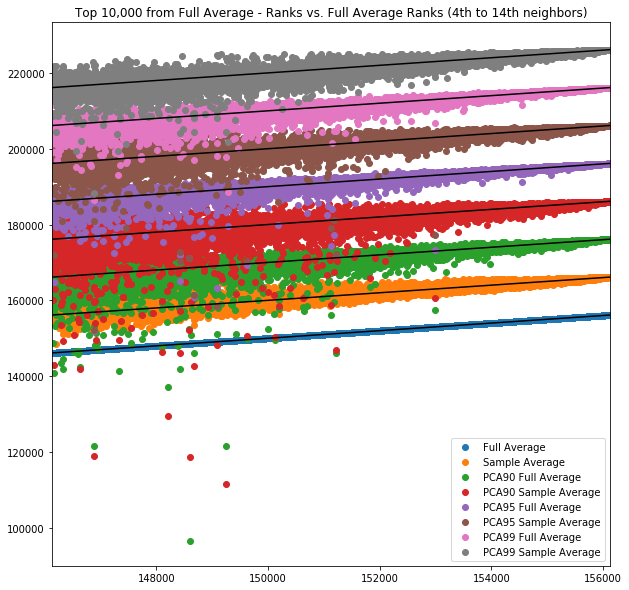

In [505]:
%matplotlib inline
scores_sorted = Q1_scores.rank(ascending=True).sort_values(by='Average').tail(10000)
plotby = 'Average'
offset=len(scores_sorted)
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(111)
ax1.scatter(scores_sorted[plotby],scores_sorted['Average'],label='Full Average')
ax1.plot(scores_sorted[plotby],scores_sorted[plotby],c='black')
ax1.scatter(scores_sorted[plotby],scores_sorted['sAverage']+1*offset,label='Sample Average')
ax1.plot(scores_sorted[plotby],scores_sorted[plotby]+1*offset,c='black')
ax1.scatter(scores_sorted[plotby],scores_sorted['PCA90_Average']+2*offset,label='PCA90 Full Average')
ax1.plot(scores_sorted[plotby],scores_sorted[plotby]+2*offset,c='black')
ax1.scatter(scores_sorted[plotby],scores_sorted['PCA90_sAverage']+3*offset,label='PCA90 Sample Average')
ax1.plot(scores_sorted[plotby],scores_sorted[plotby]+3*offset,c='black')
ax1.scatter(scores_sorted[plotby],scores_sorted['PCA95_Average']+4*offset,label='PCA95 Full Average')
ax1.plot(scores_sorted[plotby],scores_sorted[plotby]+4*offset,c='black')
ax1.scatter(scores_sorted[plotby],scores_sorted['PCA95_sAverage']+5*offset,label='PCA95 Sample Average')
ax1.plot(scores_sorted[plotby],scores_sorted[plotby]+5*offset,c='black')
ax1.scatter(scores_sorted[plotby],scores_sorted['PCA99_Average']+6*offset,label='PCA99 Full Average')
ax1.plot(scores_sorted[plotby],scores_sorted[plotby]+6*offset,c='black')
ax1.scatter(scores_sorted[plotby],scores_sorted['PCA99_sAverage']+7*offset,label='PCA99 Sample Average')
ax1.plot(scores_sorted[plotby],scores_sorted[plotby]+7*offset,c='black')
ax1.set_title('Top 10,000 from Full Average - Ranks vs. Full Average Ranks (4th to 14th neighbors)')
ax1.set_xlim((scores_sorted[plotby].min(),scores_sorted[plotby].max()))
handles,labels=ax1.get_legend_handles_labels()
ax1.legend(handles[8:],labels[8:])
plt.show()

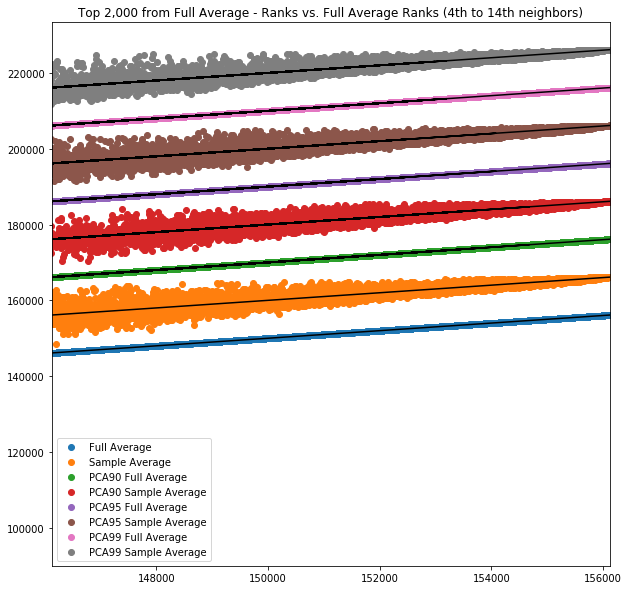

In [506]:
%matplotlib inline
scores_sorted = Q1_scores.rank(ascending=True).sort_values(by='Average').tail(10000)
plotby = 'Average'
offset=10000
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(111)
ax1.scatter(scores_sorted['Average'],scores_sorted['Average'],label='Full Average')
ax1.plot(scores_sorted['Average'],scores_sorted['Average'],c='black')
ax1.scatter(scores_sorted['Average'],scores_sorted['sAverage']+1*offset,label='Sample Average')
ax1.plot(scores_sorted['Average'],scores_sorted['Average']+1*offset,c='black')
ax1.scatter(scores_sorted['PCA90_Average'],scores_sorted['PCA90_Average']+2*offset,label='PCA90 Full Average')
ax1.plot(scores_sorted['PCA90_Average'],scores_sorted['PCA90_Average']+2*offset,c='black')
ax1.scatter(scores_sorted['PCA90_Average'],scores_sorted['PCA90_sAverage']+3*offset,label='PCA90 Sample Average')
ax1.plot(scores_sorted['PCA90_Average'],scores_sorted['PCA90_Average']+3*offset,c='black')
ax1.scatter(scores_sorted['PCA95_Average'],scores_sorted['PCA95_Average']+4*offset,label='PCA95 Full Average')
ax1.plot(scores_sorted['PCA95_Average'],scores_sorted['PCA95_Average']+4*offset,c='black')
ax1.scatter(scores_sorted['PCA95_Average'],scores_sorted['PCA95_sAverage']+5*offset,label='PCA95 Sample Average')
ax1.plot(scores_sorted['PCA95_Average'],scores_sorted['PCA95_Average']+5*offset,c='black')
ax1.scatter(scores_sorted['PCA99_Average'],scores_sorted['PCA99_Average']+6*offset,label='PCA99 Full Average')
ax1.plot(scores_sorted['PCA99_Average'],scores_sorted['PCA99_Average']+6*offset,c='black')
ax1.scatter(scores_sorted['PCA99_Average'],scores_sorted['PCA99_sAverage']+7*offset,label='PCA99 Sample Average')
ax1.plot(scores_sorted['PCA99_Average'],scores_sorted['PCA99_Average']+7*offset,c='black')
ax1.set_title('Top 2,000 from Full Average - Ranks vs. Full Average Ranks (4th to 14th neighbors)')
ax1.set_xlim((scores_sorted[plotby].min(),scores_sorted[plotby].max()))
handles,labels=ax1.get_legend_handles_labels()
ax1.legend(handles[8:],labels[8:])

plt.show()

#### Generating scores for all quarters

In [492]:
for Q_key in list(Q_dict.keys())[1:-1]:
    print("Scoring {}".format(Q_key))
    for red_key in Q_dict[Q_key].reductions.keys():
        print('Starting {}'.format(red_key))
        starttime = datetime.now()
        Q_data_scaled = qt.data_scaler(Q_dict[Q_key].reductions[red_key])
        Q_exact_scores = dist_scores(Q_data_scaled,kmin=4,kmax=14)
        columns=['{}_{}'.format(red_key,i) for i in range(4,14)]
        columns.append('{}_Average'.format(red_key))
        scoresdf = pd.DataFrame(data=Q_exact_scores.T,columns=columns,index=Q_data_scaled.index)
        print("Time to score exact neighbors: {}".format(datetime.now()-starttime))
        Q_sample_scores = dist_scores_s(Q_data_scaled,samp_size=10000,n_iter=10,kmin=4,kmax=14)
        columns=['{}_s{}'.format(red_key,i) for i in range(4,14)]
        columns.append('{}_sAverage'.format(red_key))
        scoresdf_s = pd.DataFrame(data=Q_sample_scores.T,columns=columns,index=Q_data_scaled.index)
        print("Total time to score: {}".format(datetime.now()-starttime))
        for col in scoresdf_s.columns:
            scoresdf[col]=scoresdf_s[col]

        for col in scoresdf.columns:
            Q_dict[Q_key].scores[col]=scoresdf[col]
    Q_dict[Q_key].save()

Scoring Q2
Starting PCA90
Time to score exact neighbors: 0:06:35.949428
Total time to score: 0:14:45.645783
Starting PCA95
Time to score exact neighbors: 0:07:43.743152
Total time to score: 0:17:37.530605
Starting PCA99
Time to score exact neighbors: 0:14:21.950956
Total time to score: 0:24:42.600828
Scoring Q3
Starting PCA90
Time to score exact neighbors: 0:02:54.405347
Total time to score: 0:07:29.546908
Starting PCA95
Time to score exact neighbors: 0:02:44.476420
Total time to score: 0:08:11.448967
Starting PCA99
Time to score exact neighbors: 0:05:30.792947
Total time to score: 0:11:06.152199
Scoring Q4
Starting PCA90
Time to score exact neighbors: 0:07:02.776203
Total time to score: 0:14:49.799392
Starting PCA95
Time to score exact neighbors: 0:12:33.185642
Total time to score: 0:21:40.475639
Starting PCA99
Time to score exact neighbors: 0:15:08.469847
Total time to score: 0:25:12.686374
Scoring Q5
Starting PCA90
Time to score exact neighbors: 0:08:48.781804
Total time to score: 0

#### Q2 and Q3 didn't download all the files originally, reprocessing here

In [843]:
with open('/home/dgiles/Documents/KeplerLCs/output/Q2.coo'.format(i),'rb') as file:
    Q_dict['Q2']=pickle.load(file)
with open('/home/dgiles/Documents/KeplerLCs/output/Q3.coo'.format(i),'rb') as file:
    Q_dict['Q3']=pickle.load(file)

In [850]:
for k in ['Q2','Q3']:
    print("Starting {}".format(k))
    starttime = datetime.now()
    Q_data_scaled = qt.data_scaler(Q_dict[k].data)
    Q_exact_scores = dist_scores(Q_data_scaled,kmin=4,kmax=14)

    columns=['{}'.format(i) for i in range(4,14)]
    columns.append('Average')
    scoresdf = pd.DataFrame(data=Q_exact_scores.T,columns=columns,index=Q_data_scaled.index)

    exacttime = datetime.now()
    print("time to calculate exact scores: {}".format(exacttime-starttime))
    Q_sample_scores = dist_scores_s(Q_data_scaled,samp_size=10000,n_iter=10,kmin=4,kmax=14)

    columns=['s{}'.format(i) for i in range(4,14)]
    columns.append('sAverage')
    scoresdf_s = pd.DataFrame(data=Q_sample_scores.T,columns=columns,index=Q_data_scaled.index)

    sampletime = datetime.now()
    print("time to calculate sample scores: {}".format(sampletime-exacttime))

    for col in scoresdf_s.columns:
        scoresdf[col]=scoresdf_s[col]

    Q_dict[k].scores = scoresdf
    #Q_dict[k].save()

Starting Q2


/home/dgiles/anaconda3/envs/KeplerFull37/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype float64, object were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
python/quarterTools.py:90: DataConversionWarning: Data with input dtype float64, object were all converted to float64 by StandardScaler.
  scaled_data = scaler.transform(data)


time to calculate exact scores: 0:14:39.693673
time to calculate sample scores: 0:10:31.467797
Starting Q3


/home/dgiles/anaconda3/envs/KeplerFull37/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype float64, object were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
python/quarterTools.py:90: DataConversionWarning: Data with input dtype float64, object were all converted to float64 by StandardScaler.
  scaled_data = scaler.transform(data)


time to calculate exact scores: 0:15:13.146502
time to calculate sample scores: 0:10:30.781894


In [851]:
for Q_key in ['Q2','Q3']:
    print("Scoring {}".format(Q_key))
    for red_key in Q_dict[Q_key].reductions.keys():
        print('Starting {}'.format(red_key))
        starttime = datetime.now()
        rdct = Q_dict[Q_key].reductions[red_key]
        Q_data_scaled = qt.data_scaler(df=rdct, nfeats=len(rdct.columns))
        Q_exact_scores = dist_scores(Q_data_scaled,kmin=4,kmax=14)
        columns=['{}_{}'.format(red_key,i) for i in range(4,14)]
        columns.append('{}_Average'.format(red_key))
        scoresdf = pd.DataFrame(data=Q_exact_scores.T,columns=columns,index=Q_data_scaled.index)
        print("Time to score exact neighbors: {}".format(datetime.now()-starttime))
        Q_sample_scores = dist_scores_s(Q_data_scaled,samp_size=10000,n_iter=10,kmin=4,kmax=14)
        columns=['{}_s{}'.format(red_key,i) for i in range(4,14)]
        columns.append('{}_sAverage'.format(red_key))
        scoresdf_s = pd.DataFrame(data=Q_sample_scores.T,columns=columns,index=Q_data_scaled.index)
        print("Total time to score: {}".format(datetime.now()-starttime))
        for col in scoresdf_s.columns:
            scoresdf[col]=scoresdf_s[col]

        for col in scoresdf.columns:
            Q_dict[Q_key].scores[col]=scoresdf[col]
    #Q_dict[Q_key].save()

Scoring Q2
Starting PCA90
Time to score exact neighbors: 0:08:09.711480
Total time to score: 0:16:54.951189
Starting PCA95
Time to score exact neighbors: 0:11:48.540270
Total time to score: 0:21:21.853721
Starting PCA99
Time to score exact neighbors: 0:15:06.658431
Total time to score: 0:25:34.911555
Scoring Q3
Starting PCA90
Time to score exact neighbors: 0:07:51.908222
Total time to score: 0:16:12.995672
Starting PCA95
Time to score exact neighbors: 0:10:21.150072
Total time to score: 0:19:46.420958
Starting PCA99
Time to score exact neighbors: 0:14:49.082362
Total time to score: 0:25:06.110675


In [503]:
for q in Q_dict.keys():
    print(q, Q_dict[q].scores.keys())

Q1 Index(['4', '5', '6', '7', '8', '9', '10', '11', '12', '13',
       ...
       'av_104_204', 'av_204_304', 'av_304_404', 'av_404_504', 'av_504_604',
       'av_604_704', 'av_704_804', 'av_804_904', 'av_904_1004', 'av_4_1004'],
      dtype='object', length=208)
Q2 Index(['4', '5', '6', '7', '8', '9', '10', '11', '12', '13', 'Average', 's4',
       's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 'sAverage',
       'PCA90_4', 'PCA90_5', 'PCA90_6', 'PCA90_7', 'PCA90_8', 'PCA90_9',
       'PCA90_10', 'PCA90_11', 'PCA90_12', 'PCA90_13', 'PCA90_Average',
       'PCA90_s4', 'PCA90_s5', 'PCA90_s6', 'PCA90_s7', 'PCA90_s8', 'PCA90_s9',
       'PCA90_s10', 'PCA90_s11', 'PCA90_s12', 'PCA90_s13', 'PCA90_sAverage',
       'PCA95_4', 'PCA95_5', 'PCA95_6', 'PCA95_7', 'PCA95_8', 'PCA95_9',
       'PCA95_10', 'PCA95_11', 'PCA95_12', 'PCA95_13', 'PCA95_Average',
       'PCA95_s4', 'PCA95_s5', 'PCA95_s6', 'PCA95_s7', 'PCA95_s8', 'PCA95_s9',
       'PCA95_s10', 'PCA95_s11', 'PCA95_s12', 'PCA95_

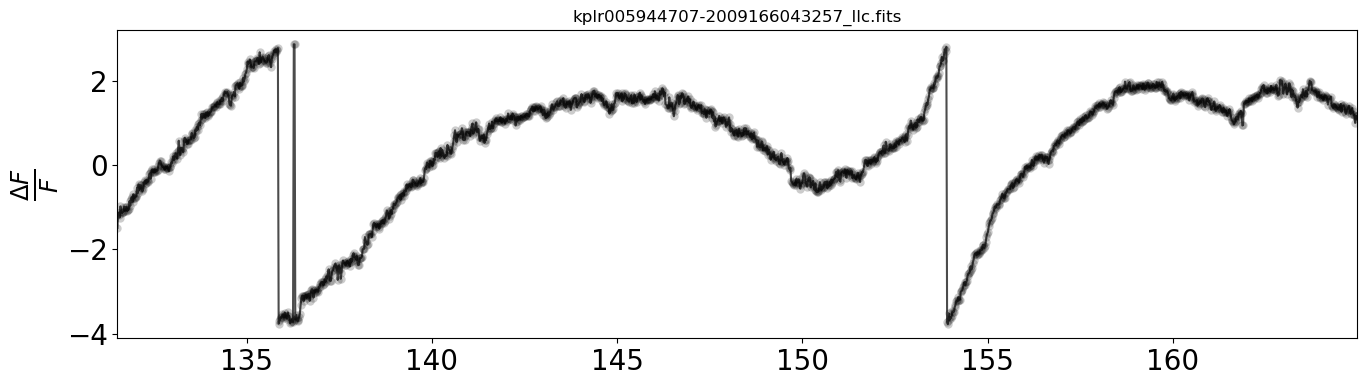

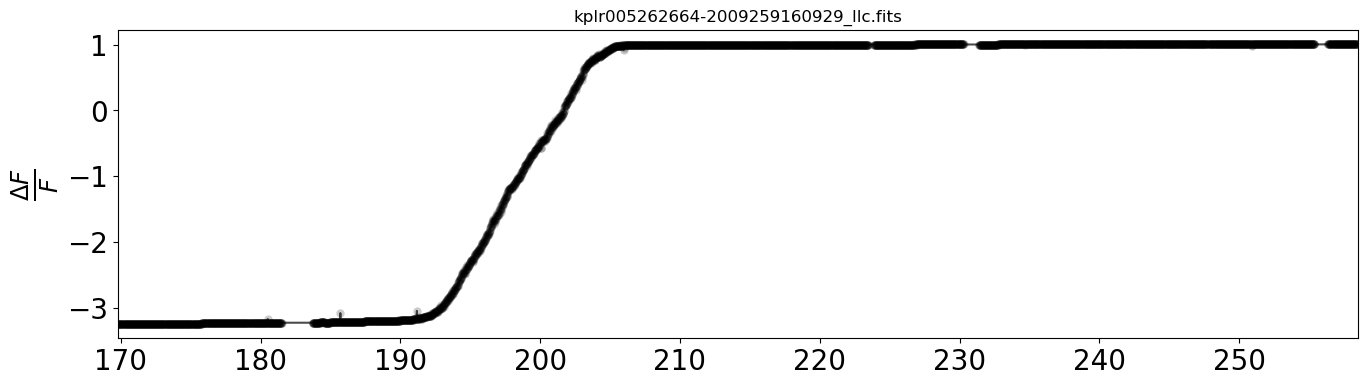

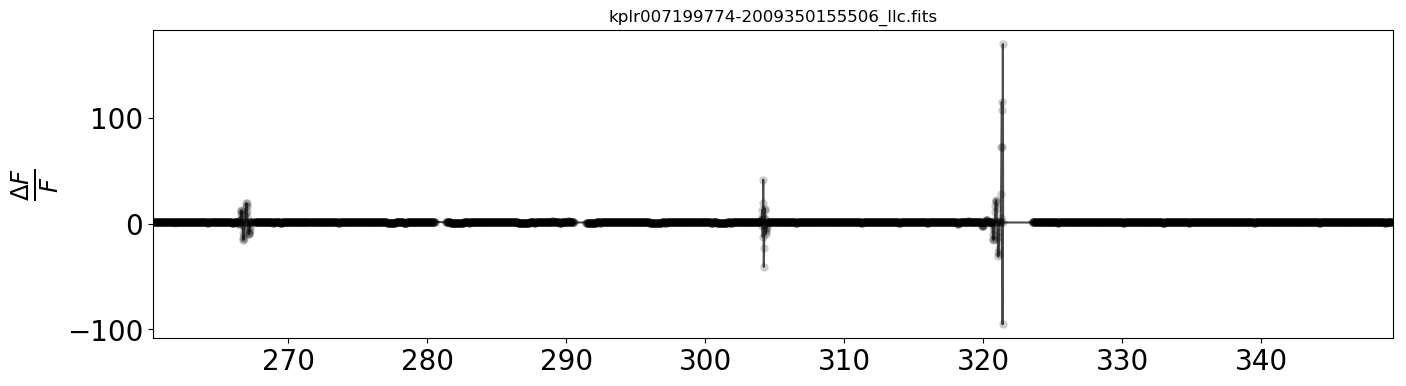

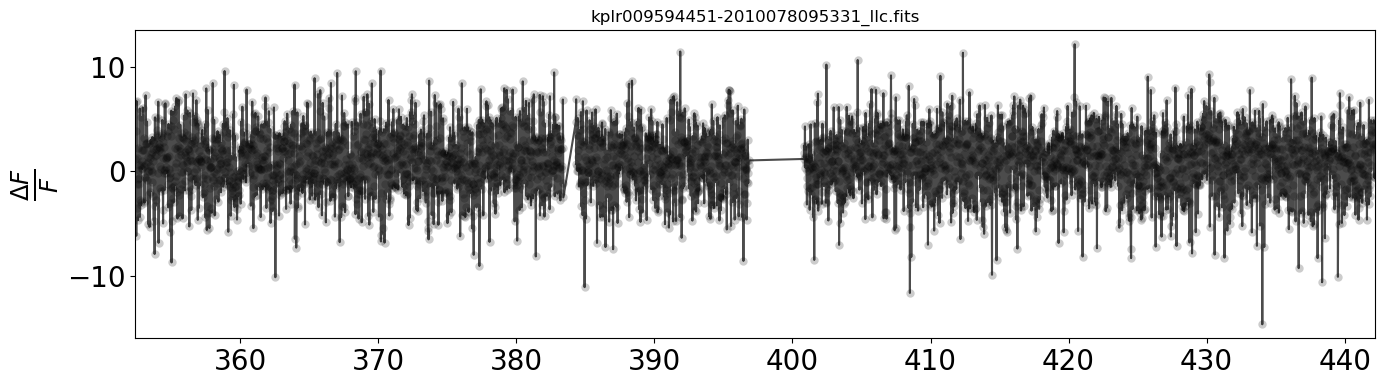

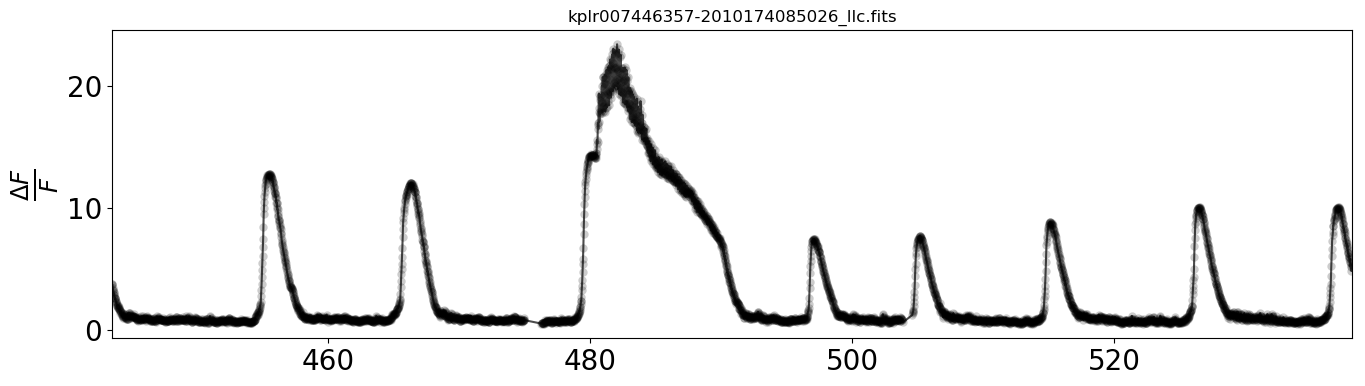

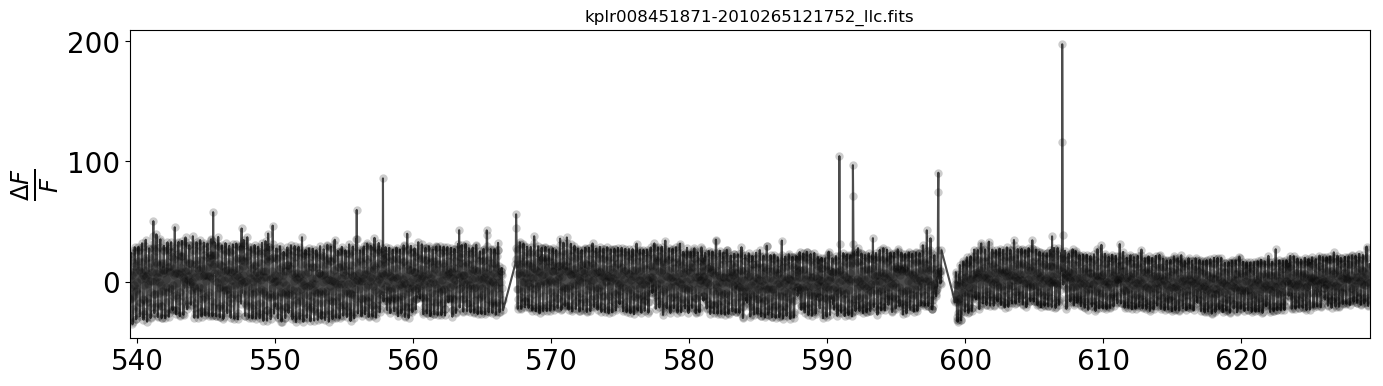

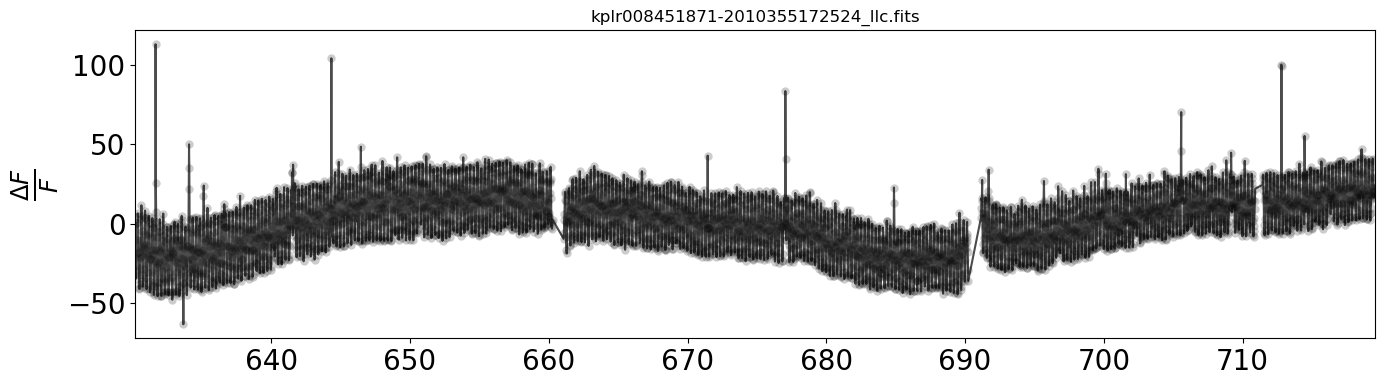

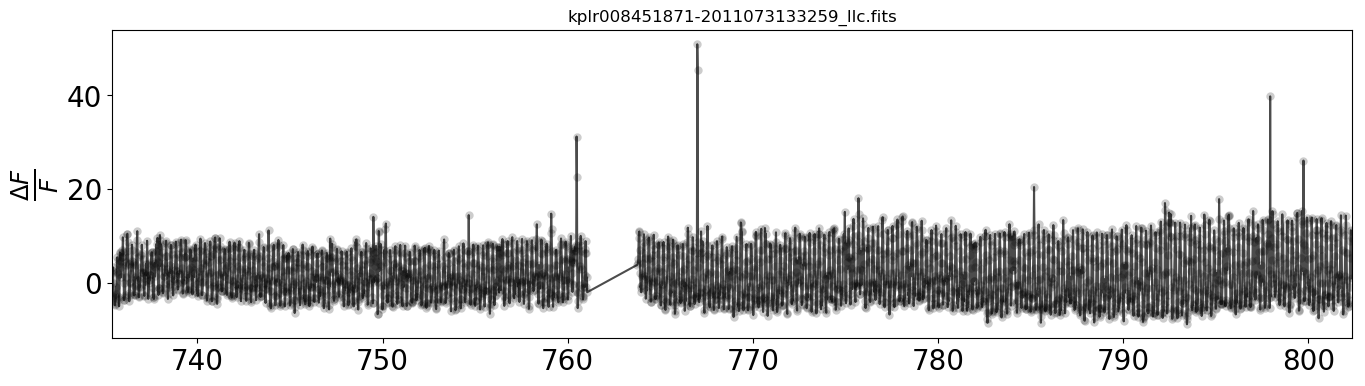

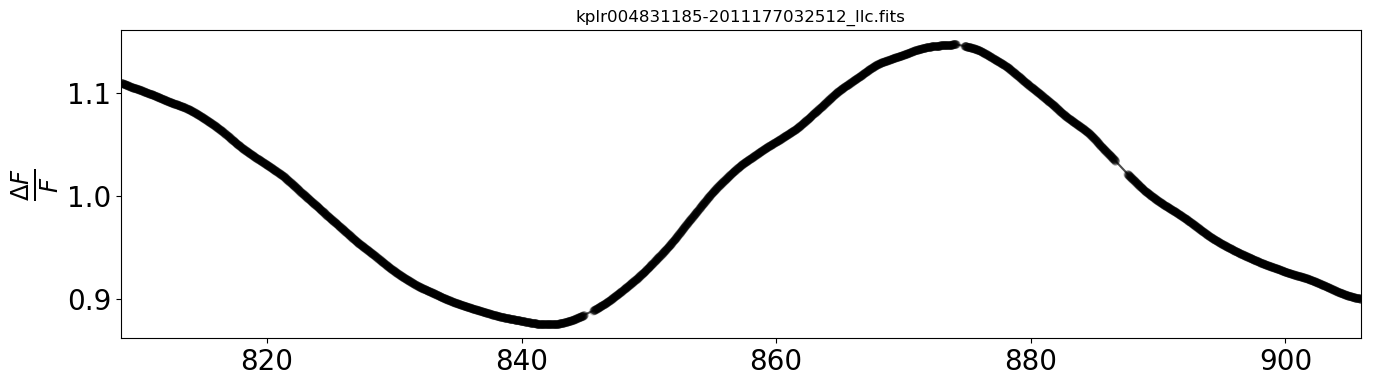

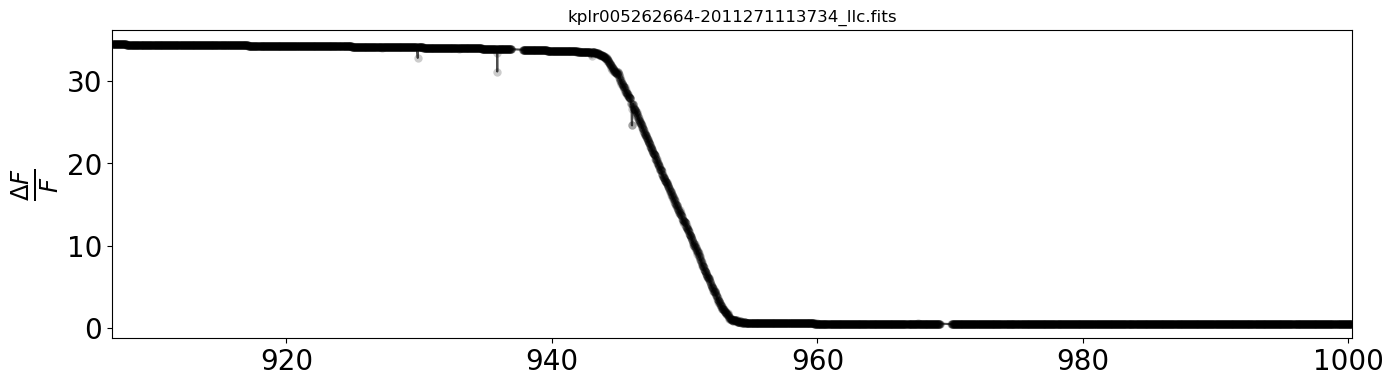

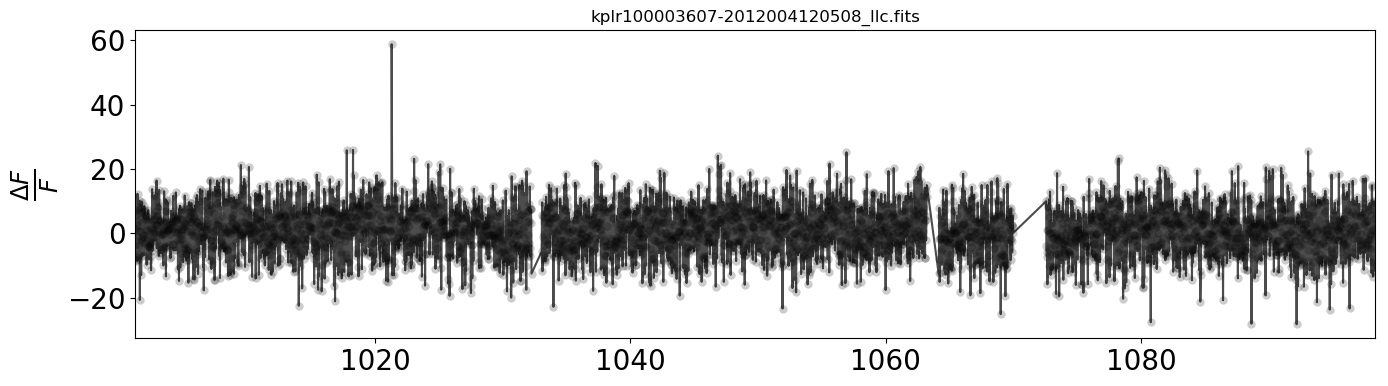

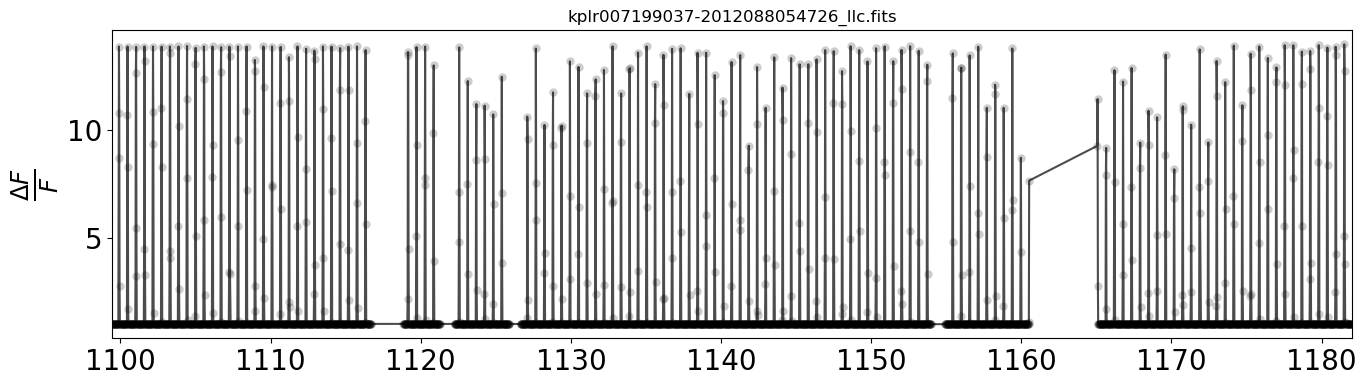

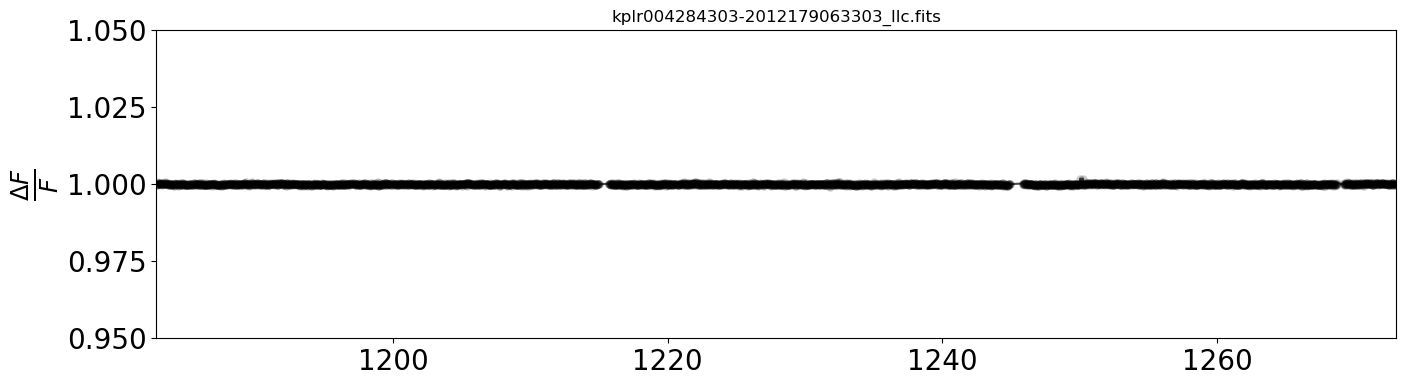

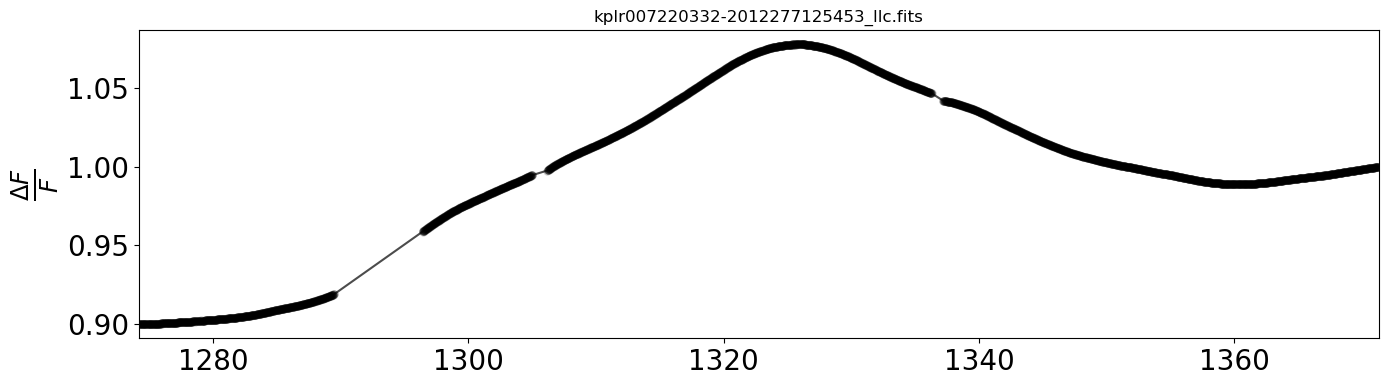

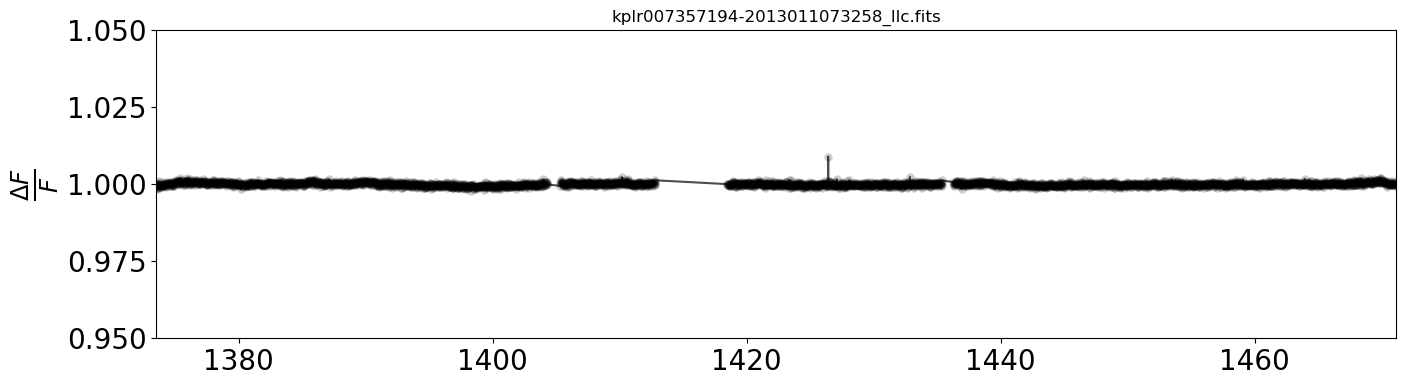

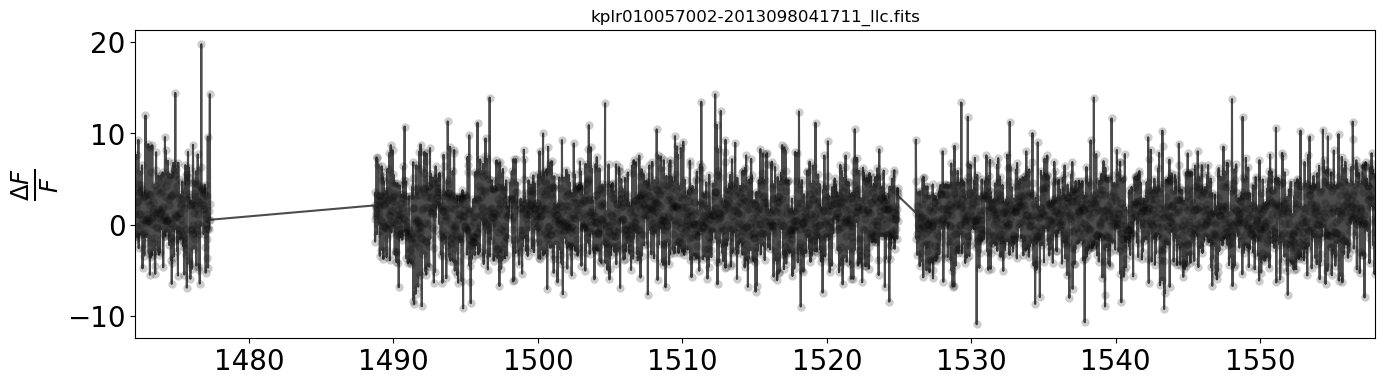

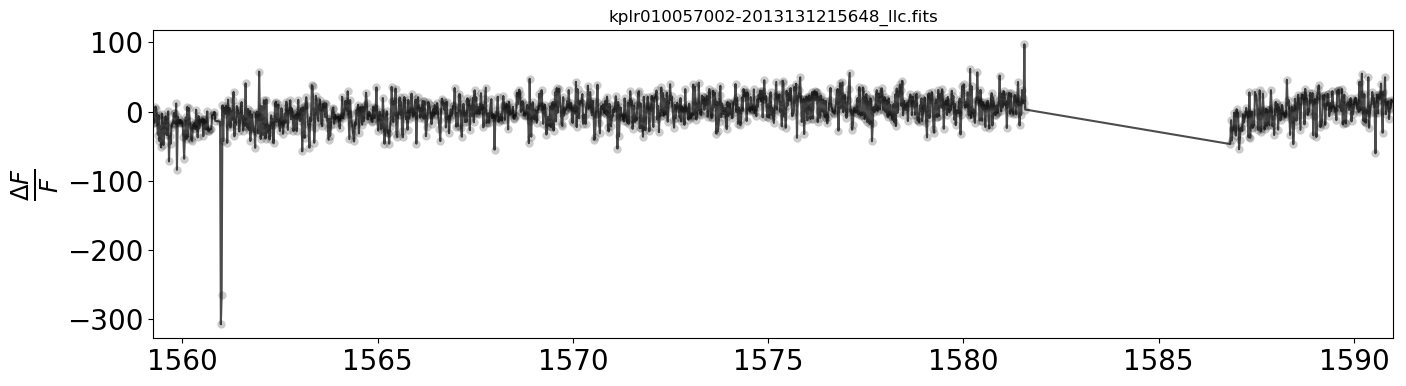

In [856]:
for Q in Q_dict.keys():
    i = Q_dict[Q].scores.rank(ascending=False).sort_values(by='PCA90_sAverage').head(100).index[0]
    qt.plot_lc(i,'/home/dgiles/Documents/KeplerLCs/fitsFiles/{}fitsfiles/'.format(Q),c='black')
    plt.title(i)

In [595]:
# Classes according to simbad (limited to sample from previous paper...)
lines = np.genfromtxt('./Variable Lists/simbad.csv',delimiter=';',skip_header=7,dtype=str)[:,1:]
simbad_full_df = pd.DataFrame(data=lines[:,1],columns=["Class"],index=[lines[:,0]])

In [658]:
df = Q_dict['Q1'].data
obj_class = []
for i in df.index:
    if 'KIC'+i[4:13] in simbad_full_df.index:
        obj_class.append(simbad_full_df.loc['KIC'+i[4:13]].Class[0])
    else:
        obj_class.append('Undef')
Q_dict['Q1'].data['simbad_class']=obj_class

"""
Exact kNN scores produced for all quarters.
"""
```
for k in Q_dict.keys():
    print("Starting {}".format(k))
    starttime = datetime.now()
    Q_data_scaled = qt.data_scaler(Q_dict[k].data)
    Q_exact_scores = dist_scores(Q_data_scaled,kmin=4,kmax=14)
    
    columns=['{}'.format(i) for i in range(4,14)]
    columns.append('Average')
    scoresdf = pd.DataFrame(data=Q_exact_scores.T,columns=columns,index=Q_data_scaled.index)
    
    exacttime = datetime.now()
    print("time to calculate exact scores: {}".format(exacttime-starttime))
    Q_sample_scores = dist_scores_s(Q_data_scaled,samp_size=10000,n_iter=10,kmin=4,kmax=14)
    
    columns=['s{}'.format(i) for i in range(4,14)]
    columns.append('sAverage')
    scoresdf_s = pd.DataFrame(data=Q_sample_scores.T,columns=columns,index=Q_data_scaled.index)

    sampletime = datetime.now()
    print("time to calculate sample scores: {}".format(sampletime-starttime))
    
    for col in scoresdf_s.columns:
        scoresdf[col]=scoresdf_s[col]
    
    Q_dict[k].scores = scoresdf
    Q_dict[k].save()
```

|Quarter|time to calc exact scores|total time (exact+sample)|
|-------|-------------------------|-------------------------|
|Q1|12:35.76|22:15.23|
|Q2|12:34.39|23:08.03|
|Q3|05:27.76|12:39.33|
|Q4|17:11.87|29:15.34|
|Q5|14:49.00|25:35.21|
|Q6|16:32.17|27:19.16|
|Q7|14:55.92|25:31.84|
|Q8|20:23.49|31:40.92|
|Q9|10:00.81|22:04.77|
|Q10|12:39.31|22:34.53|
|Q11|16:24.55|27:25.22|
|Q12|15:11.95|26:40.49|
|Q13|09:38.58|20:21.77|
|Q14|15:38.77|27:21.49|
|Q15|15:34.69|29:05.41|
|Q16|17:16.13|28:47.02|
|Q17|16:59.16|27:53.98|
